# Predicting sentiment of smartphone reviews from Ukrainian eCommerce marketplace

# Step 1: Read dataset and perform basic preprocessing

## Read datasets

In [1]:
# Commented line with modules to install if was not one previously 
#! pip install dateparser 
#!pip install advertools
#!pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [2]:
#Import necessary libraries
from datetime import datetime
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import dateparser
from datetime import timedelta
from datetime import date
import ktrain
from ktrain import text
import advertools as adv
from langdetect import detect
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

%config IPCompleter.greedy=True

#Remove limitations for displaying of tables in pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
#Get the list of file names from the folder where this script is located 
files_names = glob.glob("smartphone_reviews_*.csv")

#Iterate through retrieved file names to read files into DataFrames.
#File name contains date when the import was made, we will extract it to replace  "today" and "yesterday" values in review_date column in dataframes with the appropriate values. 
df_names = []
for i, j in enumerate(files_names):
    date = datetime.strptime(j.split('smartphone_reviews_')[1].split('.csv')[0], '%Y-%m-%d')
    date_yesterday = date - timedelta(1)
    data = pd.read_csv(files_names[i])
    data['review_date'] = [i.replace('сьогодні', str(date)) if 'сьогодні' in i else i for i in data['review_date']]
    data['review_date'] = [i.replace('вчора', str(date_yesterday)) if 'вчора' in i else i for i in data['review_date']]
    globals()['data_%s' % i] = data
    print('DataFrame {} was added'.format('data_%s' % i))
    df_names.append(globals()['data_%s' % i])

DataFrame data_0 was added
DataFrame data_1 was added
DataFrame data_2 was added


In [4]:
#Concatenate DataFrames and drop duplicates
data = pd.concat(df_names)
data.drop_duplicates(subset=['review_id'], inplace=True)

In [5]:
#Look at short info of DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7106 entries, 0 to 5119
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   comment_link                     7106 non-null   object 
 1   product_title                    7106 non-null   object 
 2   product_price                    7106 non-null   float64
 3   review_id                        7106 non-null   int64  
 4   review_date                      7106 non-null   object 
 5   review_text                      7106 non-null   object 
 6   review_rating                    7106 non-null   int64  
 7   thumbs_up                        7106 non-null   int64  
 8   thumbs_down                      7106 non-null   int64  
 9   product_advatages_disadvantages  7106 non-null   object 
 10  product_advatages                7106 non-null   object 
 11  product_disadvantages            7105 non-null   object 
dtypes: float64(1), int64

In [6]:
#Unique values count for all columns
for i in data.columns:
   print("{} -- {} unique values".format(i, len(data[i].unique())))

comment_link -- 7106 unique values
product_title -- 849 unique values
product_price -- 358 unique values
review_id -- 7106 unique values
review_date -- 1135 unique values
review_text -- 6720 unique values
review_rating -- 6 unique values
thumbs_up -- 83 unique values
thumbs_down -- 58 unique values
product_advatages_disadvantages -- 4008 unique values
product_advatages -- 3741 unique values
product_disadvantages -- 2849 unique values


In [7]:
#Check unique values for columns with <100 unique values
for i in ['review_rating', 'thumbs_up', 'thumbs_down']:
    print(data[i].value_counts())

0    3030
5    2532
4    625 
1    449 
3    251 
2    219 
Name: review_rating, dtype: int64
0      3332
1      1331
2      680 
3      425 
4      257 
5      189 
6      108 
7      98  
13     65  
8      52  
9      52  
10     51  
12     43  
11     35  
14     28  
18     26  
16     23  
17     23  
20     22  
15     21  
19     20  
23     15  
24     13  
22     13  
21     11  
25     10  
30     9   
27     9   
26     7   
37     6   
41     6   
36     6   
56     6   
38     5   
29     5   
40     5   
31     5   
35     5   
39     5   
33     4   
32     4   
48     4   
28     4   
34     3   
44     3   
43     3   
62     3   
54     3   
79     3   
42     3   
77     2   
46     2   
63     2   
98     2   
58     2   
50     2   
64     2   
73     2   
113    2   
52     2   
49     2   
53     2   
57     2   
69     2   
80     1   
91     1   
108    1   
94     1   
71     1   
59     1   
55     1   
47     1   
158    1   
114    1   
86     1   
116   

## Fix data format, parsing issues, check for duplicates

From the head of the dataset and statistics we can see:
- comment_link, product_title, product_price, review_id, review_rating, thumbs_up, product_disadvantages – these columns looks good
- review_date – needs to be converted to datatime format
- review_text – let's look at records with the same text to check for duplicates
- product_advatages_disadvantages – this column is duplicating, it was left in the scaping script in case there is a need to  check that we have full information in product_advatages/product_disadvantages clolumns. Seems like everything is fine, so we can drop this column.
- product_advatages – we need to strip redundant symbols from this column and leave only text about product advantages, we can do this by striping everything after ‘/dd></div>’

Also let’s add a column which will contain all text related to the review: Concatenation of review_text, product_advatages, product_disadvantages columns, so we can use it later on modeling stage.

In [8]:
#Lets have a closer look at format of review_date values
print(data.review_date.value_counts()[:30])

 20 лютого 2021          74
 06 квітня 2021          64
 05 квітня 2021          63
 21 лютого 2021          63
 18 лютого 2021          58
 2021-04-07 00:00:00     58
 17 лютого 2021          57
 22 лютого 2021          55
 04 квітня 2021          52
 15 лютого 2021          51
 16 лютого 2021          46
 10 лютого 2021          45
 13 лютого 2021          45
 2021-02-23 00:00:00     45
 25 березня 2021         45
 24 березня 2021         45
 08 лютого 2021          44
 14 лютого 2021          43
 19 лютого 2021          42
 09 лютого 2021          41
 27 березня 2021         37
 01 квітня 2021          36
 31 березня 2021         34
 07 лютого 2021          34
 20 березня 2021         33
 12 лютого 2021          33
 21 березня 2021         33
 22 березня 2021         33
 29 березня 2021         32
 28 березня 2021         32
Name: review_date, dtype: int64


In [9]:
#Convert review_date to datetime format and look at the results
data.review_date = [dateparser.parse(date, date_formats=['%d %m %Y']) for date in data.review_date]
print(data.review_date.value_counts()[:30])

2021-02-20    74
2021-04-06    64
2021-02-21    63
2021-04-05    63
2021-04-07    58
2021-02-18    58
2021-02-17    57
2021-02-22    55
2021-04-04    52
2021-02-15    51
2021-02-23    48
2021-02-16    46
2021-03-24    45
2021-02-10    45
2021-02-13    45
2021-03-25    45
2021-02-08    44
2021-02-14    43
2021-02-19    42
2021-02-09    41
2021-03-27    37
2021-04-01    36
2021-03-31    34
2021-02-07    34
2021-03-20    33
2021-03-22    33
2021-02-12    33
2021-03-21    33
2021-03-28    32
2021-03-29    32
Name: review_date, dtype: int64


In [10]:
#Delete product_advatages_disadvantages column
data = data.drop(columns=['product_advatages_disadvantages'])

In [11]:
#review_text – look at records with the same text to check for duplicates
display(pd.concat(g for _, g in data.groupby("review_text") if len(g) > 1))

comment_link  \
3197  https://rozetka.com.ua/ua/tecno_spark_4_kc2_royal_purple/p141981519/comments/#id=47568233                               
139   https://rozetka.com.ua/ua/xiaomi_749703/p282416913/comments/#id=49706561                                                
1141  https://rozetka.com.ua/ua/apple_iphone_12_256gb_green/p245162317/comments/#id=49150262                                  
2016  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49552939                            
1701  https://rozetka.com.ua/ua/samsung_sm_a207fzrdsek/p138459953/comments/#id=48346233                                       
2234  https://rozetka.com.ua/ua/samsung_sm_m115fzknsek/p208369267/comments/#id=48925200                                       
4979  https://rozetka.com.ua/ua/15968704/p15968704/comments/#id=19335260                                                      
5656  https://rozetka.com.ua/ua/33763271/p33763271/comments/#id=32563944                                                      
4580  https://rozetka.com.ua/ua/39174216/p39174216/comments/#id=33273792                                                      
5252  https://rozetka.com.ua/ua/44037392/p44037392/comments/#id=32564100                                                      
69    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48625332                             
93    https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=49238177                                       
95    https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=49236163                                       
144   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49389019                                       
175   https://rozetka.com.ua/ua/samsung_galaxy_m51_6_128gb_black/p249014389/comments/#id=49377107                             
252   https://rozetka.com.ua/ua/motorola_page0015rs/p245661253/comments/#id=49105115                                          
256   https://rozetka.com.ua/ua/motorola_page0015rs/p245661253/comments/#id=49338573                                          
301   https://rozetka.com.ua/ua/huawei_p40_lite_6_128_black/p190067606/comments/#id=49195673                                  
390   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_3_64gb_midnight_grey/p209754337/comments/#id=49217106                     
426   https://rozetka.com.ua/ua/zte_blade_a7s_3_64gb_blue/p250624431/comments/#id=48820817                                    
446   https://rozetka.com.ua/ua/samsung_sm_a107fdbdsek/p272332106/comments/#id=49392013                                       
458   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_pro_6_64gb_tropical_green/p209755855/comments/#id=49286606                
461   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_pro_6_64gb_tropical_green/p209755855/comments/#id=49314953                
472   https://rozetka.com.ua/ua/realme_2001000187010/p208543585/comments/#id=49129988                                         
480   https://rozetka.com.ua/ua/zte_blade_a7_2020_2_32gb_black/p155606256/comments/#id=49091905                               
486   https://rozetka.com.ua/ua/zte_blade_a7_2020_2_32gb_black/p155606256/comments/#id=49088458                               
524   https://rozetka.com.ua/ua/huawei_51095kyp/p217174627/comments/#id=49015313                                              
533   https://rozetka.com.ua/ua/huawei_51095kyp/p217174627/comments/#id=49303091                                              
584   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_4_128gb_midnight_grey/p209755831/comments/#id=49374316                    
678   https://rozetka.com.ua/ua/huawei_p40_pro_8_256gb_silver_slim_box/p270684826/comments/#id=48924016                       
821   https://rozetka.com.ua/ua/apple_mhdm3/p260937056/comments/#id=49268094                                                  
914   https://rozetka.com.ua/ua/samsung_sm_g780

In [12]:
#lets remove "None" values from the result
display(pd.concat(g for _, g in data[data.review_text != 'None'].groupby("review_text") if len(g) > 1))

comment_link  \
3197  https://rozetka.com.ua/ua/tecno_spark_4_kc2_royal_purple/p141981519/comments/#id=47568233                     
139   https://rozetka.com.ua/ua/xiaomi_749703/p282416913/comments/#id=49706561                                      
1141  https://rozetka.com.ua/ua/apple_iphone_12_256gb_green/p245162317/comments/#id=49150262                        
2016  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49552939                  
1701  https://rozetka.com.ua/ua/samsung_sm_a207fzrdsek/p138459953/comments/#id=48346233                             
2234  https://rozetka.com.ua/ua/samsung_sm_m115fzknsek/p208369267/comments/#id=48925200                             
4979  https://rozetka.com.ua/ua/15968704/p15968704/comments/#id=19335260                                            
5656  https://rozetka.com.ua/ua/33763271/p33763271/comments/#id=32563944                                            
4580  https://rozetka.com.ua/ua/39174216/p39174216/comments/#id=33273792                                            
5252  https://rozetka.com.ua/ua/44037392/p44037392/comments/#id=32564100                                            
4500  https://rozetka.com.ua/ua/55909140/p55909140/comments/#id=44439318                                            
4505  https://rozetka.com.ua/ua/55909140/p55909140/comments/#id=44439330                                            
63    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=49368790                   
1245  https://rozetka.com.ua/ua/apple_iphone_12_256gb_green/p245162317/comments/#id=49368811                        
4322  https://rozetka.com.ua/ua/39172056/p39172056/comments/#id=44694689                                            
5415  https://rozetka.com.ua/ua/google_pixel_3a_xl_4_64gb_just_black/p211123159/comments/#id=44694701               
5508  https://rozetka.com.ua/ua/64244873/p64244873/comments/#id=44998227                                            
5541  https://rozetka.com.ua/ua/55379070/p55379070/comments/#id=44998239                                            
1794  https://rozetka.com.ua/ua/61852957/p61852957/comments/#id=48192626                                            
217   https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_silver_sm_g998bzsgsek/p272562741/comments/#id=49574041   
4656  https://rozetka.com.ua/ua/55908714/p55908714/comments/#id=46320348                                            
5043  https://rozetka.com.ua/ua/55908702/p55908702/comments/#id=46318857                                            
3480  https://rozetka.com.ua/ua/sigma_mobile_x_style_s5501_black/p69486002/comments/#id=47947401                    
3487  https://rozetka.com.ua/ua/sigma_mobile_x_style_s5501_black/p69486002/comments/#id=46590549                    
503   https://rozetka.com.ua/ua/apple_mhgq3/p260982411/comments/#id=48760764                                        
990   https://rozetka.com.ua/ua/apple_iphone_se_128gb_white/p205228447/comments/#id=48760791                        
2958  https://rozetka.com.ua/ua/oppo_a72_128gb_black/p215656807/comments/#id=49366419                               
2967  https://rozetka.com.ua/ua/oppo_a72_128gb_black/p215656807/comments/#id=49366599                               
4743  https://rozetka.com.ua/ua/65306178/p65306178/comments/#id=29667576                                            
5651  https://rozetka.com.ua/ua/34523231/p34523231/comments/#id=34028248                                            
1576  https://rozetka.com.ua/ua/blackview_6931548305811/p121183798/comments/#id=46247064                            
4877  https://rozetka.com.ua/ua/47739742/p47739742/comments/#id=41284293                                            
4378  https://rozetka.com.ua/ua/44688640/p44688640/comments/#id=39696216                                            
4619  https://rozetka.com.ua/ua/17918364/p17918364/comments/#id=26801039                                            
4668  

*Some values in review text are indeed the same, but I would conclude that these are unique records as they are related to different products, written with different dates and sometimes have different product_advatages/ product_disadvantages text. Often the same text is some standard questions or feedback or just the same question that person wrote about different products.*

In [13]:
#Fix parsing of product_advatages column
data.product_advatages = [i.split('</dd>')[0] if i != "None" else 'None' for i in data.product_advatages]
display(data.head())

comment_link  \
0  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49293156   
1  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49190491   
2  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49299159   
3  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49289173   
4  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49224598   

                                                                                                                 product_title  \
0   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
1   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
2   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
3   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
4   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    

   product_price  review_id review_date  \
0  39999.0        49293156  2021-02-13    
1  39999.0        49190491  2021-02-04    
2  39999.0        49299159  2021-02-14    
3  39999.0        49289173  2021-02-13    
4  39999.0        49224598  2021-02-07    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          review_text  \
0  Розетка, подскажите телефон без сканера лица и желательно без сканера отпечатков пальцев. Спасибо                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
1  Датчик адаптивной яркости работает не корректно в темноте дисплей светит на 90 процентов. Когда тресешь телефон раздается звук как будто внутри что то отвалилось, до этого s9 plus таких проблем не было, да Самсунг уже не тот))                                                                                                                                                   

## Check review_text content to drop rows with not enough information 

During checking reviews content, I noticed that some reviews seem to be quite low-quality. Usually such reviews contained questions instead of actual review or they contained very short text. Lets check these 2 cases.

In [14]:
#Check review_text with questions
qestions = []
for i in data.review_text:
    if str(i).endswith('?') and (len(i)<170):
        qestions.append(i)
        
print(len(qestions))
display(data[data['review_text'].isin(qestions)])

#After examining different lengths of questions in review_text column it was decided to use 170 symbols as threshold.
#Most of questions below this length doesn’t contain sentiment about product, just question. Some records have advatages/disadvantages description, but since there is not may of them - we will just drop such rows.
data = data[~data['review_text'].isin(qestions)]

1227


comment_link  \
3     https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49289173              
4     https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49224598              
14    https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49360664                                        
20    https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49376079                                        
38    https://rozetka.com.ua/ua/samsung_sm_a025fzkesek/p268107536/comments/#id=49237413                                       
44    https://rozetka.com.ua/ua/samsung_sm_a025fzkesek/p268107536/comments/#id=49345727                                       
47    https://rozetka.com.ua/ua/samsung_sm_a315fzwvsek/p199478977/comments/#id=49388167                                       
52    https://rozetka.com.ua/ua/samsung_sm_a315fzwvsek/p199478977/comments/#id=49337149                                       
58    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=49212854                             
59    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=49183405                             
84    https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=45169849                                       
87    https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=49366802                                       
97    https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49311737                                       
98    https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49229241                                       
101   https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49228322                                       
102   https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49375557                                       
104   https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49312979                                       
107   https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49374060                                       
109   https://rozetka.com.ua/ua/realme_7_pro_8_128gb_mirror_blue/p254407693/comments/#id=49227472                             
115   https://rozetka.com.ua/ua/realme_7_pro_8_128gb_mirror_blue/p254407693/comments/#id=49342112                             
116   https://rozetka.com.ua/ua/realme_7_pro_8_128gb_mirror_blue/p254407693/comments/#id=49246871                             
117   https://rozetka.com.ua/ua/realme_7_pro_8_128gb_mirror_blue/p254407693/comments/#id=49337233                             
122   https://rozetka.com.ua/ua/motorola_pajw0006rs/p245662303/comments/#id=49349771                                          
134   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49337244                                       
137   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49391226                                       
140   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49178060                                       
142   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49207483                                       
145   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49371635                                       
147   https://rozetka.com.ua/ua/xiaomi_657896/p224125945/comments/#id=49317405                                                
153   https://rozetka.com.ua/ua/xiaomi_657896/p224125945/comments/#id=49350190                                                
157   https://rozetka.com.ua/ua/xiaomi_657896/p224125945/comments/#id=49298545                                                
173   https://rozetka.com.ua/ua/samsung_galaxy_

In [15]:
#Check short review_text values
short_comments = []
for i in data.review_text:
    if (len(str(i))<2) and i not in qestions and i!='None':
        short_comments.append(i)
        
print(len(short_comments))
display(data[data['review_text'].isin(short_comments)])

#After examining short reviews it was decided to leave them as a lot of short reviews contained reviewer opinion on the product.
#We will drop only 1 row without review_text/product_advatages/product_disadvantages.
data = data[~data['review_id'].isin(['32563944'])]

2


comment_link  \
4979  https://rozetka.com.ua/ua/15968704/p15968704/comments/#id=19335260   
5656  https://rozetka.com.ua/ua/33763271/p33763271/comments/#id=32563944   

                      product_title  product_price  review_id review_date  \
4979   S-TELL M556 Black             1999.0         19335260  2017-07-12    
5656   Blackview A10 Barley Golden   2086.0         32563944  2018-09-13    

     review_text  review_rating  thumbs_up  thumbs_down  \
4979  .           0              0          0             
5656  .           4              0          0             

                                                                                                                                                                              product_advatages  \
4979  Неплохая камера для телефона за 70$ ,экран хоть и большеват для такого разрешения но лесенок и пикселей не наблюдается,стекло довольно прочное,технология miravision,углы обзора экрана,.   
5656  None                                                                                                                                                                                        

                                                                                                                                                                   product_disadvantages  
4979  Перегрев,он выгружает фоновые приложения из памяти,плохое стандартное приложение камеры ,поганая оптимизация системы , баги системы,динамик тихий ,скользящий задник смартфона   ,  
5656  None

## Create column full_text which contains all text related  to the review: review_text, product_advatages, product_disadvantages

In [16]:
#Create full_text column
data["full_text"] = data["review_text"] +' Преймущества: ' +data["product_advatages"] + '. Недостатки: ' + data.product_disadvantages

## Take care of Missing values

review_rating
0    1901
1    436 
2    213 
3    245 
4    601 
5    2482
Name: comment_link, dtype: int64

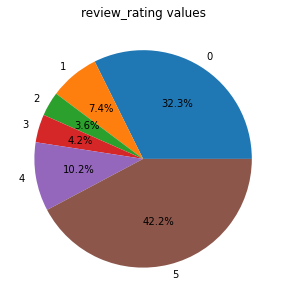

In [17]:
#At first let's look at review_rating values count
display(data.groupby('review_rating')['comment_link'].count())
#Plot a diagram of review_rating values count
labels, frequencies = np.unique(data.review_rating.values, return_counts = True)
plt.figure(figsize = (5, 5))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title('review_rating values')
plt.savefig('review_rating_values.png', transparent=True)
plt.show()

*From checking the web-site we can see that there are no reviews with 0 stars, so in fact 32.3% of retrieved reviews don’t have a rating. So predicting sentiment of reviews based on text can be useful, it will allow to get the information about consumers sentiment for significant fraction of the reviews that currently are not classified.*

In [18]:
#During web-scraping script preparation missing values were marked as None. 
#Lets set 0 in review_rating and None in other columns as NaN 
#Also lets set as NaN values of full_text column in which we don’t have any text
data['review_rating'] = data['review_rating'].replace(0, np.NaN)
data = data.replace('None', np.NaN)
data['full_text'] = data['full_text'].replace('None Преймущества: None. Недостатки: None', np.NaN)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5878 entries, 0 to 5119
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   comment_link           5878 non-null   object        
 1   product_title          5878 non-null   object        
 2   product_price          5878 non-null   float64       
 3   review_id              5878 non-null   int64         
 4   review_date            5878 non-null   datetime64[ns]
 5   review_text            5594 non-null   object        
 6   review_rating          3977 non-null   float64       
 7   thumbs_up              5878 non-null   int64         
 8   thumbs_down            5878 non-null   int64         
 9   product_advatages      3733 non-null   object        
 10  product_disadvantages  3699 non-null   object        
 11  full_text              5705 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory u

# Step 2: Exploratory data analysis 

In this section, we will make a cursory exploration of retrieved reviews data.

##  review_rating exploration  

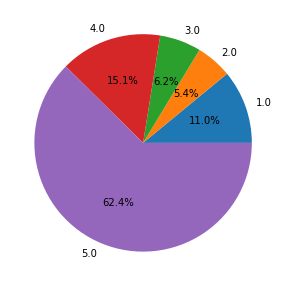

In [19]:
#Plot review_rating values for not NA recods
data_wth_rating = pd.DataFrame(data[data.review_rating.notna()])
labels, frequencies = np.unique(data_wth_rating.review_rating.values, return_counts = True)
plt.figure(figsize = (5,5))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

*The target variable classes are imbalanced.
We can see that the biggest fraction of reviews is the most positive ones: about 62% percent of reviews have rating 5 stars and the second biggest fraction is also positive reviews with the rating of 4 stars (15%).*

## product_price VS review_rating relation   

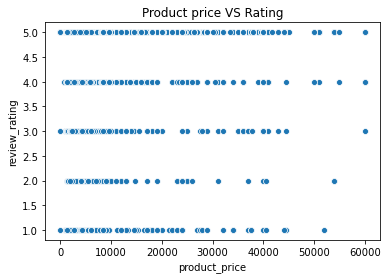

In [20]:
#Visualize relation of Product price VS Rating
ax = sns.scatterplot(data=data_wth_rating, x="product_price", y="review_rating")
ax.set_title('Product price VS Rating')
plt.show()

*From the plot above we can see that more expensive products seem to have tendency to have higher ratings.
To see the trend more clearly lets divide products into 4 price segments and plot average rating.*

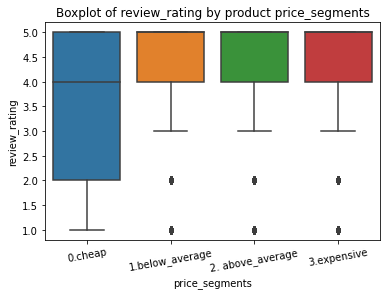

review_rating
price_segments                 
0.cheap           3.664062     
1.below_average   4.125767     
2. above_average  4.301829     
3.expensive       4.430878

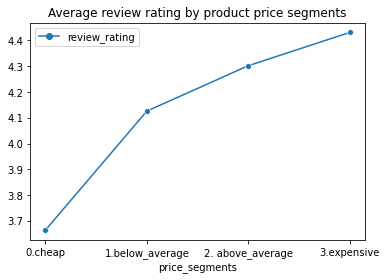

In [21]:
#Plot review_rating in product price_segments
data_wth_rating['price_segments'] = pd.qcut(data_wth_rating.product_price, 4, labels=["0.cheap", "1.below_average", "2. above_average", "3.expensive"])
ax =sns.boxplot(x="price_segments", y="review_rating", data=data_wth_rating)
plt.setp(ax.get_xticklabels(), rotation=10)
ax.set_title('Boxplot of review_rating by product price_segments')
plt.show()

#Create price segments and check avarage rating 
review_rating_by_price_segments = pd.DataFrame(data_wth_rating.groupby('price_segments')['review_rating'].mean())
display(review_rating_by_price_segments)
g = sns.lineplot(data=review_rating_by_price_segments, markers=True)
g.set_title('Average review rating by product price segments')
plt.show()

## review_date VS review_date relation   

'The earliest review is from 2015 year and the latest review is from 2021 year'

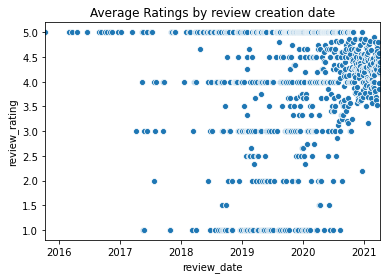

In [22]:
#Explore reviews cretion timeline
display("The earliest review is from {} year and the latest review is from {} year".format(data.review_date.min().year, data.review_date.max().year))

rating_avg = data_wth_rating.groupby('review_date')['review_rating'].mean().reset_index()
ax = sns.scatterplot(data = rating_avg, x='review_date', y='review_rating')
ax.set_title('Average Ratings by review creation date')
ax.set(xlim=(data_wth_rating.review_date.min(), data_wth_rating.review_date.max()))
plt.show()

*From the plot above we can see that in our dataset there are more new reviews than old ones and new reviews also seem to have higher ratings. 
Probably it’s connected with the way how reviews were web-scraped: we retrieved only first portion of reviews of each product that was initially displayed in the web-page (before pressing “Show more” button).  It’s could be that the web-site shows the recent and positive reviews first. It could be the reason why we got mainly recent positive reviews.*

Even though there is some specifics on how data was collected it should be enough to test what performance we can expect from the sentiment prediction model, so we can proceed further with the project.

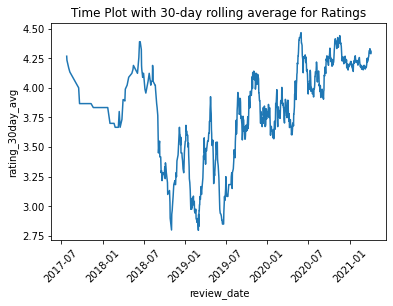

In [23]:
#Explore reviews timeline with rolling mean to see if there is a trend
rating_avg['rating_30day_avg'] = rating_avg.review_rating.rolling(30).mean().shift(-3)
ax = sns.lineplot(data = rating_avg, x='review_date', y='rating_30day_avg')
ax.set_title('Time Plot with 30-day rolling average for Ratings')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

*The plot above with 30-day rolling average removes noise from the data and shows more general trend of how average ratings in our dataset have been changing in time. Seems like average rating for smartphones grows up since summer 2019.*

## review_text - language detection

In [24]:
#Drop rows with NA values for review_text
review_text_clean = pd.DataFrame(data_wth_rating.dropna(subset = ['review_text']))

#Detect language
lang=[]
for i in review_text_clean.review_text:
    try:
      lang.append(detect(i))
    except:
        lang.append('None')
review_text_clean['lang'] = lang

lang=[]
for i in review_text_clean.review_text:
    try:
        b = TextBlob(i)  
        lang.append(b.detect_language())
    except:
        lang.append('None')
review_text_clean['lang'] = lang


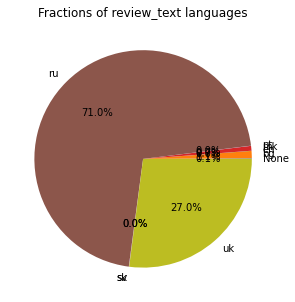

In [25]:
#Plot review_text languages
labels, frequencies = np.unique(review_text_clean.lang.values, return_counts = True)
plt.figure(figsize = (5, 5))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title('Fractions of review_text languages')
plt.show()

In [26]:
#Look at rows which was not detected as ru or uk language
review_text_clean[(review_text_clean.lang != 'ru') & (review_text_clean.lang != 'uk')]

comment_link  \
50    https://rozetka.com.ua/ua/samsung_sm_a315fzwvsek/p199478977/comments/#id=49272421                                       
60    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=49368869                             
62    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=49201778                             
78    https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49310861                            
110   https://rozetka.com.ua/ua/realme_7_pro_8_128gb_mirror_blue/p254407693/comments/#id=49233541                             
314   https://rozetka.com.ua/ua/zte_blade_a7_2_32gb_black/p90749888/comments/#id=49315579                                     
359   https://rozetka.com.ua/ua/xiaomi_657892/p224063905/comments/#id=48906647                                                
430   https://rozetka.com.ua/ua/zte_blade_a7s_3_64gb_blue/p250624431/comments/#id=49395365                                    
681   https://rozetka.com.ua/ua/huawei_p40_pro_8_256gb_silver_slim_box/p270684826/comments/#id=49369839                       
766   https://rozetka.com.ua/ua/motorola_razr_5g_gold/p247505413/comments/#id=48974568                                        
785   https://rozetka.com.ua/ua/blackview_6931548306108/p237544495/comments/#id=48148956                                      
862   https://rozetka.com.ua/ua/apple_iphone_12_pro_max_256gb_pacific_blue/p245162569/comments/#id=48897458                   
946   https://rozetka.com.ua/ua/xiaomi_mi_10t_6_128gb_cosmic_black/p252742451/comments/#id=48073402                           
1036  https://rozetka.com.ua/ua/pocophone_691532/p246763123/comments/#id=47563259                                             
1357  https://rozetka.com.ua/ua/tecno_spark_6_4_128gb_ocean_blue/p261922161/comments/#id=49325003                             
1794  https://rozetka.com.ua/ua/61852957/p61852957/comments/#id=48192626                                                      
1798  https://rozetka.com.ua/ua/61852957/p61852957/comments/#id=48470597                                                      
1894  https://rozetka.com.ua/ua/83793234/p83793234/comments/#id=45043031                                                      
2202  https://rozetka.com.ua/ua/samsung_galaxy_a01_2_16gb_red/p173920111/comments/#id=49139856                                
2234  https://rozetka.com.ua/ua/samsung_sm_m115fzknsek/p208369267/comments/#id=48925200                                       
2270  https://rozetka.com.ua/ua/oppo_a31_lake_green/p193260096/comments/#id=47398542                                          
2414  https://rozetka.com.ua/ua/realme_6941399004832/p208489687/comments/#id=49144032                                         
2453  https://rozetka.com.ua/ua/huawei_y6_2019_blue/p76631166/comments/#id=41646594                                           
2464  https://rozetka.com.ua/ua/huawei_51094wbw/p170986929/comments/#id=47350412                                              
2717  https://rozetka.com.ua/ua/2e_e450a_2018_dualsim_black/p51927996/comments/#id=47320002                                   
2809  https://rozetka.com.ua/ua/meizu_m6t_3_32gb_blue/p216463345/comments/#id=46905486                                        
2852  https://rozetka.com.ua/ua/realme_6941399000230/p237047725/comments/#id=48691424                                         
2919  https://rozetka.com.ua/ua/oppo_find_x2_ocean_black/p194528244/comments/#id=47452668                                     
3081  https://rozetka.com.ua/ua/doogee_x100_1_8gb_blue/p120928978/comments/#id=45355991                                       
3154  https://rozetka.com.ua/ua/oppo_reno3_8_128gb_auroral_blue/p200222839/comments/#id=47174165                              
3162  https://rozetka.com.ua/ua/huawei_p30_lite_4_64gb_midnightblack/p158250128/comments/#id=47921979                         
3237  https://rozetka.com.ua/ua/realme_5_3_64_b

*From inspecting the table above we can make conclusion that language for some records was not detected correctly: some reviews in Russian and Ukrainian were wrongly classified as other languages (Bulgarian, Macedonian, Rumanian, etc). 
Since the fraction of misclassified records is nor significant, we still can conclude that about ¾ of all reviews are written in Russian and ¼ in Ukrainian languages.*

## review_text exploration - Unigrams, Bigrams, Trigrams

In this section we will explore the most common words and phrases in the review_text column for positive and negative reviews.  To do so we will create the new column review_sentiment which will correspond to the value “1” for positive reviews (with 4 and 5 stars) and “0” for negative reviews (with 1, 2 and 3 stars).

In [27]:
#Create review_sentiment to show negative and positive reviews
data_wth_rating.loc[(data_wth_rating['review_rating']==1)|(data_wth_rating['review_rating']==2)|(data_wth_rating['review_rating']==3), 'review_sentiment'] = '0' 
data_wth_rating.loc[(data_wth_rating['review_rating']==4)|(data_wth_rating['review_rating']==5), 'review_sentiment'] = '1'

#Drop rows with NA values for review_text
review_text_clean = pd.DataFrame(data_wth_rating.dropna(subset = ['review_text']))

#Create boolean masks to filter negative and positive reviews 
negative_rev = review_text_clean['review_sentiment'] == '0'
positive_rev = review_text_clean['review_sentiment'] == '1'

#Create STOPWORDS list: take pre-made lists in russian and ukrainian and complement them
STOPWORDS_ukr = adv.stopwords['ukrainian']
STOPWORDS_rus = adv.stopwords['russian']
STOPWORDS = STOPWORDS_ukr.union(STOPWORDS_rus)
STOPWORDS = STOPWORDS.union(['-', 'і', ",", "1", "2", "3", "4", "5", "6", "7", "8", "9", "телефон", "—", ".", "под", "10", "телефон", "телефон,", "смартфон"])

#Fuction to create ngrams
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

#Number of records to show in plot
N = 10

#Function to genarate plots with ngrams
def create_view_of_n_grams(n_gram):
    ###Takes number of n_gram to show n_grams of review_text for negative and positive reviews
    positive_unigrams = {}
    negative_unigrams = {}

    for rev in review_text_clean[negative_rev]['review_text']:
        for word in generate_ngrams(rev, n_gram=n_gram):
            try:
                negative_unigrams[word] += 1
            except:
                negative_unigrams[word] =1
        

    for rev in review_text_clean[positive_rev]['review_text']:
        for word in generate_ngrams(rev, n_gram=n_gram):
            try:
                positive_unigrams[word] += 1
            except:
                positive_unigrams[word] =1
        
    df_neg = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])
    df_pos = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])

    
    fig, axes = plt.subplots(ncols=2, figsize=(18, 10), dpi=45)
    plt.tight_layout()

    sns.barplot(y=df_neg[0].values[:N], x=df_neg[1].values[:N], ax=axes[0], color='red')
    sns.barplot(y=df_pos[0].values[:N], x=df_pos[1].values[:N], ax=axes[1], color='green')
    for i in range(2):
        axes[i].spines['right'].set_visible(False)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', labelsize=13)
        axes[i].tick_params(axis='y', labelsize=13)

    axes[0].set_title(f'Top {N} most common {n_gram}-grams in negative reviews', fontsize=15)
    axes[1].set_title(f'Top {N} most common {n_gram}-grams in positive reviews', fontsize=15)
        
    plt.show()

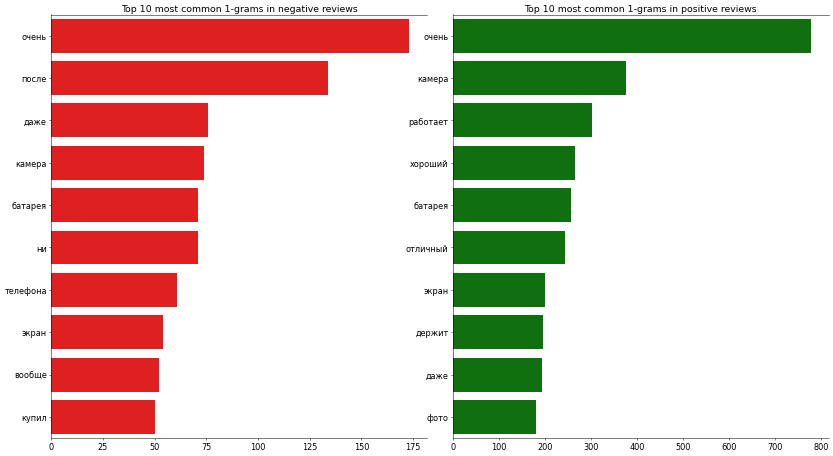

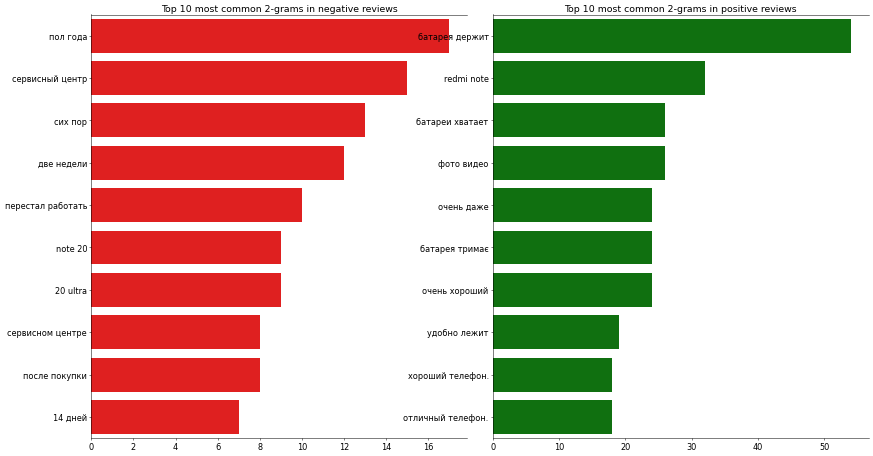

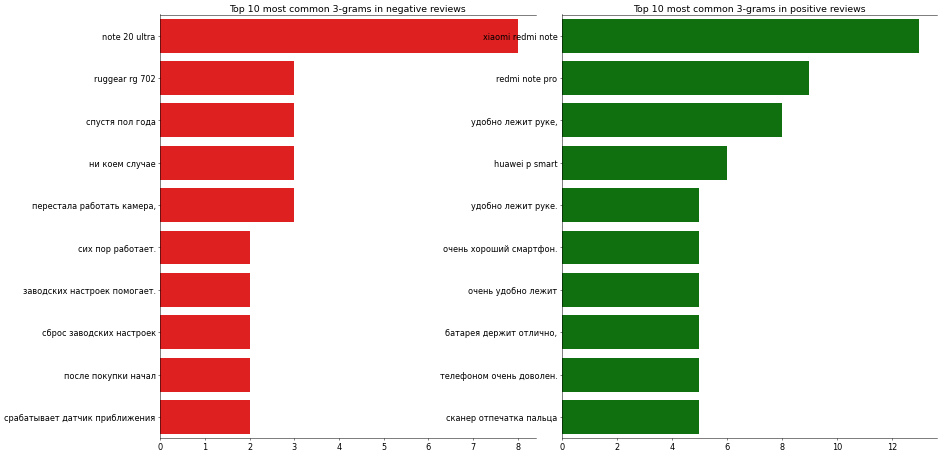

In [28]:
#View Unigrams, Bigrams, Trigrams
create_view_of_n_grams(1)
create_view_of_n_grams(2)
create_view_of_n_grams(3)

*From the generated plots we can see that unigrams are pretty similar for negative and plosive reviews, while bigrams and trigrams differ much more and also make much more sense as they catch more context from the text.*

*In case of using these features in modeling it’s advisable to explore most common unigrams in more depth. 
Possibly it’s better to use only bigrams and trigrams as features for modeling as unigrams might not capture the context of positive or negative sentiment.*

##  review_text - Meta Features analysis
Lets have a look at meta Features of review_text:
- word_count - number of words in text
- unique_word_count - number of unique words in text
- stop_word_count - number of stop words in text
- mean_word_length - average character count in words
- char_count - number of characters in text
- punctuation_count - number of punctuations in text
- stop_word_count - number of stopwords in text

In [29]:
#Define Function to calculate Meta Features
punctuation = ['#', '@', '!', '?', '+', '&', '-', '$', '=', '<', '>', '|', '{', '}', '^', "'", '(', ')' , '[', ']', '*', '%', '...', "'", ".", ':', ';']
def calculate_meta_features (dataframe, text_column):
### This function adds text meta_features to dataframe: word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count, stop_word_count
### Function has two arguments:
### - dataframe - dataframe to analyse,it has to contain text for analysis,  
### - text_column - name of the column for which to calculate meta features.
    # word_count
    dataframe.loc[:, 'word_count_{}'.format(text_column)] = dataframe[text_column].apply(lambda x: len(str(x).split()))
    # unique_word_count
    dataframe.loc[:, 'unique_word_count_{}'.format(text_column)] = dataframe[text_column].apply(lambda x: len(set(str(x).split())))
    # mean_word_length
    dataframe.loc[:, 'mean_word_length_{}'.format(text_column)] = dataframe[text_column].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    # char_count
    dataframe.loc[:, 'char_count_{}'.format(text_column)] = dataframe[text_column].apply(lambda x: len(str(x)))
    # punctuation_count
    dataframe.loc[:, 'punctuation_count_{}'.format(text_column)] = dataframe[text_column].apply(lambda x: len([c for c in str(x) if c in punctuation]))
    # stop_word_count
    dataframe.loc[:, 'stop_word_count_{}'.format(text_column)] = dataframe[text_column].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

#Calculate Meta Features of review_text using function
calculate_meta_features(review_text_clean, 'review_text')

In [30]:
review_text_clean.head()

comment_link  \
1  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49190491   
2  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49299159   
5  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49228123   
6  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49212385   
8  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49285480   

                                                                                                                 product_title  \
1   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
2   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
5   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
6   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
8   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    

   product_price  review_id review_date  \
1  39999.0        49190491  2021-02-04    
2  39999.0        49299159  2021-02-14    
5  39999.0        49228123  2021-02-08    
6  39999.0        49212385  2021-02-06    
8  39999.0        49285480  2021-02-12    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             review_text  \
1  Датчик адаптивной яркости работает не корректно в темноте дисплей светит на 90 процентов. Когда тресешь телефон раздается звук как будто внутри что то отвалилось, до этого s9 plus таких проблем не было, да Самсунг уже не тот))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
2  Я не буду расписывать плюсы телефона - о них можно почитать в обзорах. Поэтому напишу о том, почему лично у меня с телефоном пока не сложились отношения. Отпечаток пальца работает плохо. То срабатывает без проблем, то с 5й попытки не желае

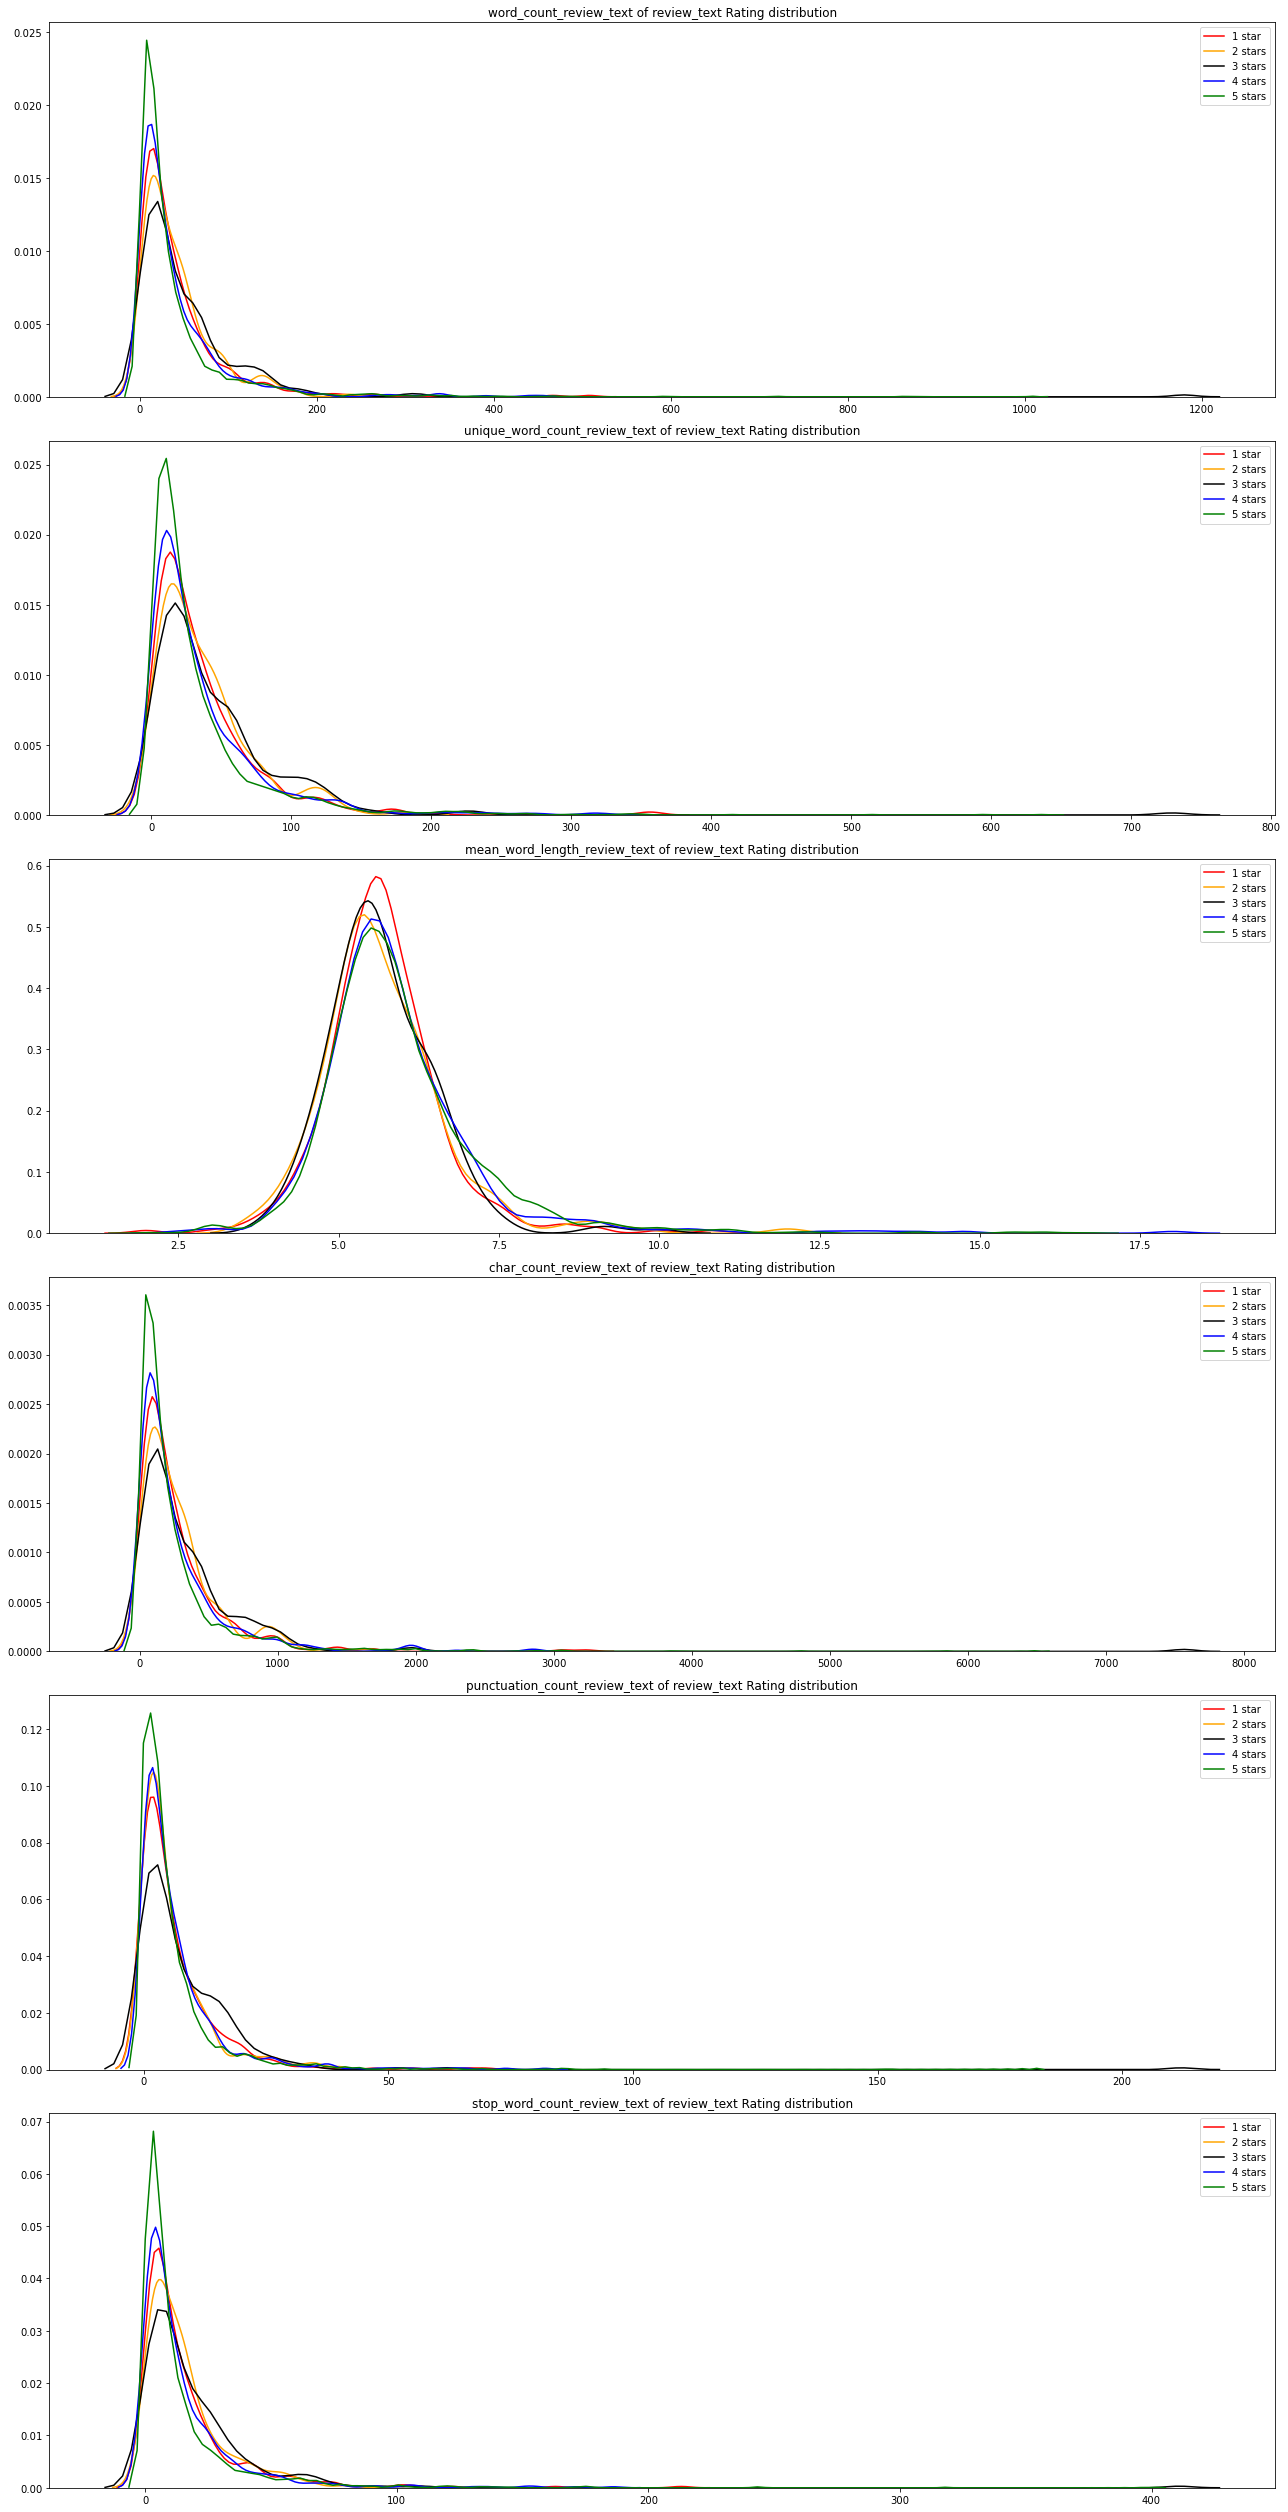

In [31]:
#Plot meta features distribution in relation to Target variable - Review rating
fig, axes = plt.subplots(6, figsize=(18,35))
for count, column in enumerate(['word_count_review_text', 'unique_word_count_review_text', 'mean_word_length_review_text', 'char_count_review_text', 'punctuation_count_review_text', 'stop_word_count_review_text']):
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_rating'] == 1.0][column], shade=False, color='red', label ='1 star')
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_rating'] == 2.0][column], shade=False, color='orange', label ='2 stars')
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_rating'] == 3.0][column], shade=False, color='black', label ='3 stars')
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_rating'] == 4.0][column], shade=False, color='blue', label ='4 stars')
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_rating'] == 5.0][column], shade=False, color='green', label ='5 stars')
    axes[count].set_title('{} of review_text Rating distribution'.format(column))
fig.tight_layout()

*From the plots we can see that distribution of almost all meta features of review_text slightly differ for reviews with different rating.*

*But generated plots look pretty cluttered, let’s simplify them by displaying distribution of review_text meta features only for negative and positive reviews.*

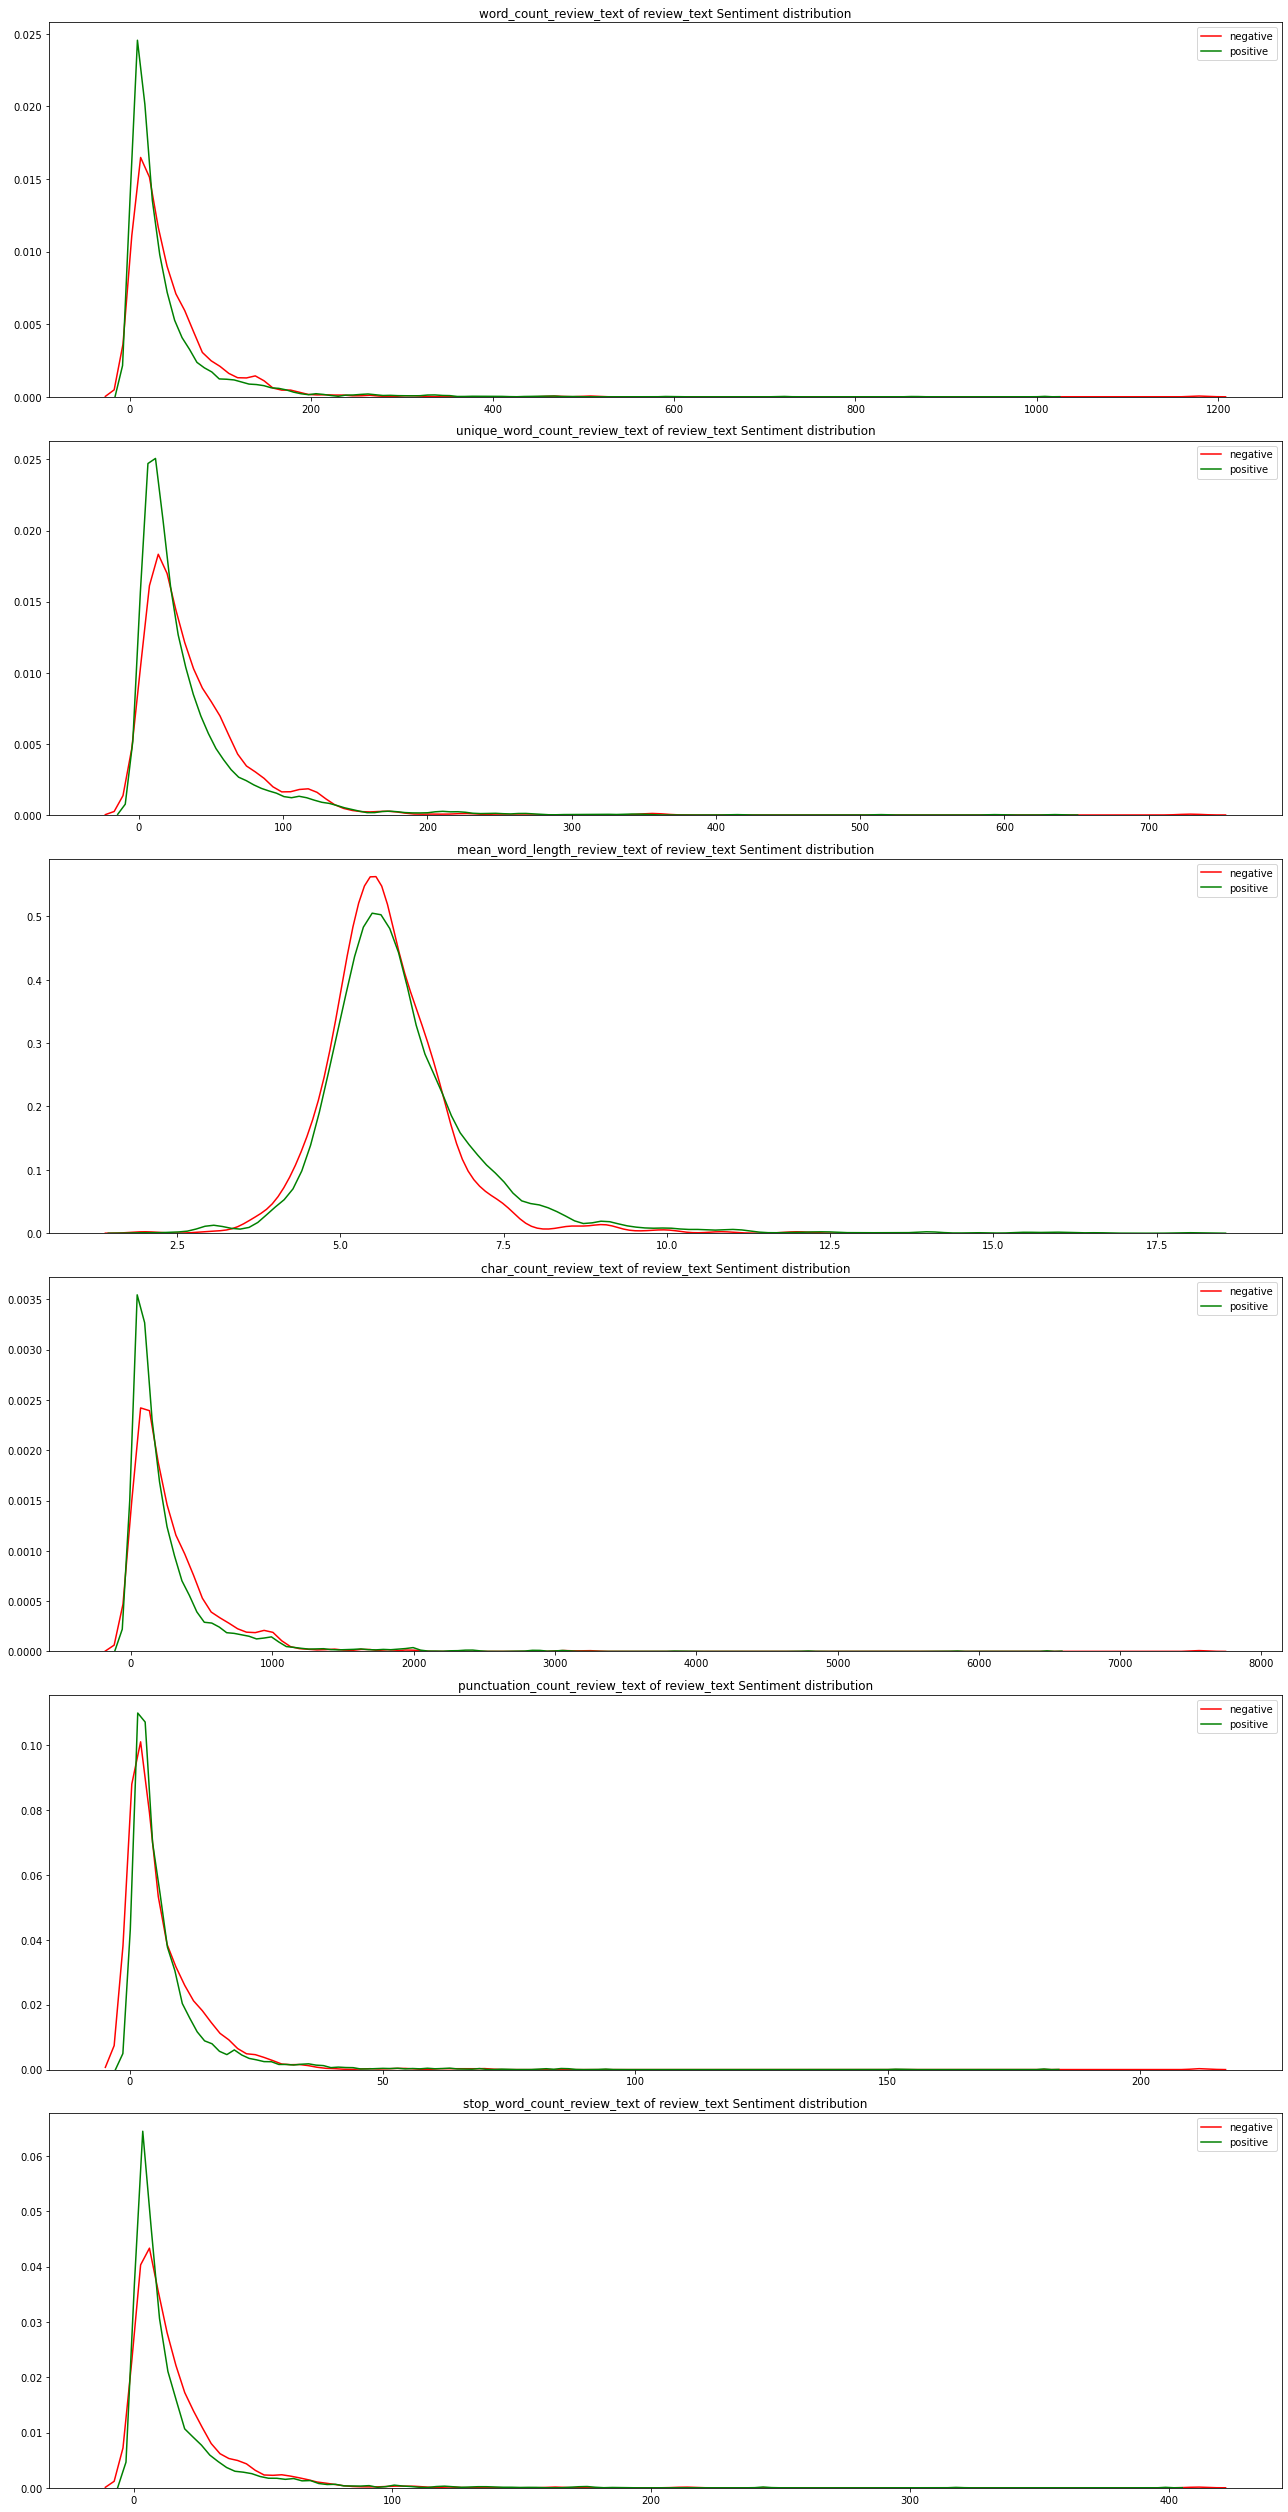

In [32]:
#Plot meta features distribution in relation to simplified Target variable - Review rating
fig, axes = plt.subplots(6, figsize=(18,35))
for count, column in enumerate(['word_count_review_text', 'unique_word_count_review_text', 'mean_word_length_review_text', 'char_count_review_text', 'punctuation_count_review_text', 'stop_word_count_review_text']):
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_sentiment'] == '0'][column], shade=False, color='red', label ='negative')
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_sentiment'] == '1'][column], shade=False, color='green', label ='positive')
    axes[count].set_title('{} of review_text Sentiment distribution'.format(column))
fig.tight_layout()

*Distributions of majority of meta features are slightly different for reviews with negative and positive sentiment. These features can be helpful in modeling stage.*

##  product_advatages - Meta Features analysis

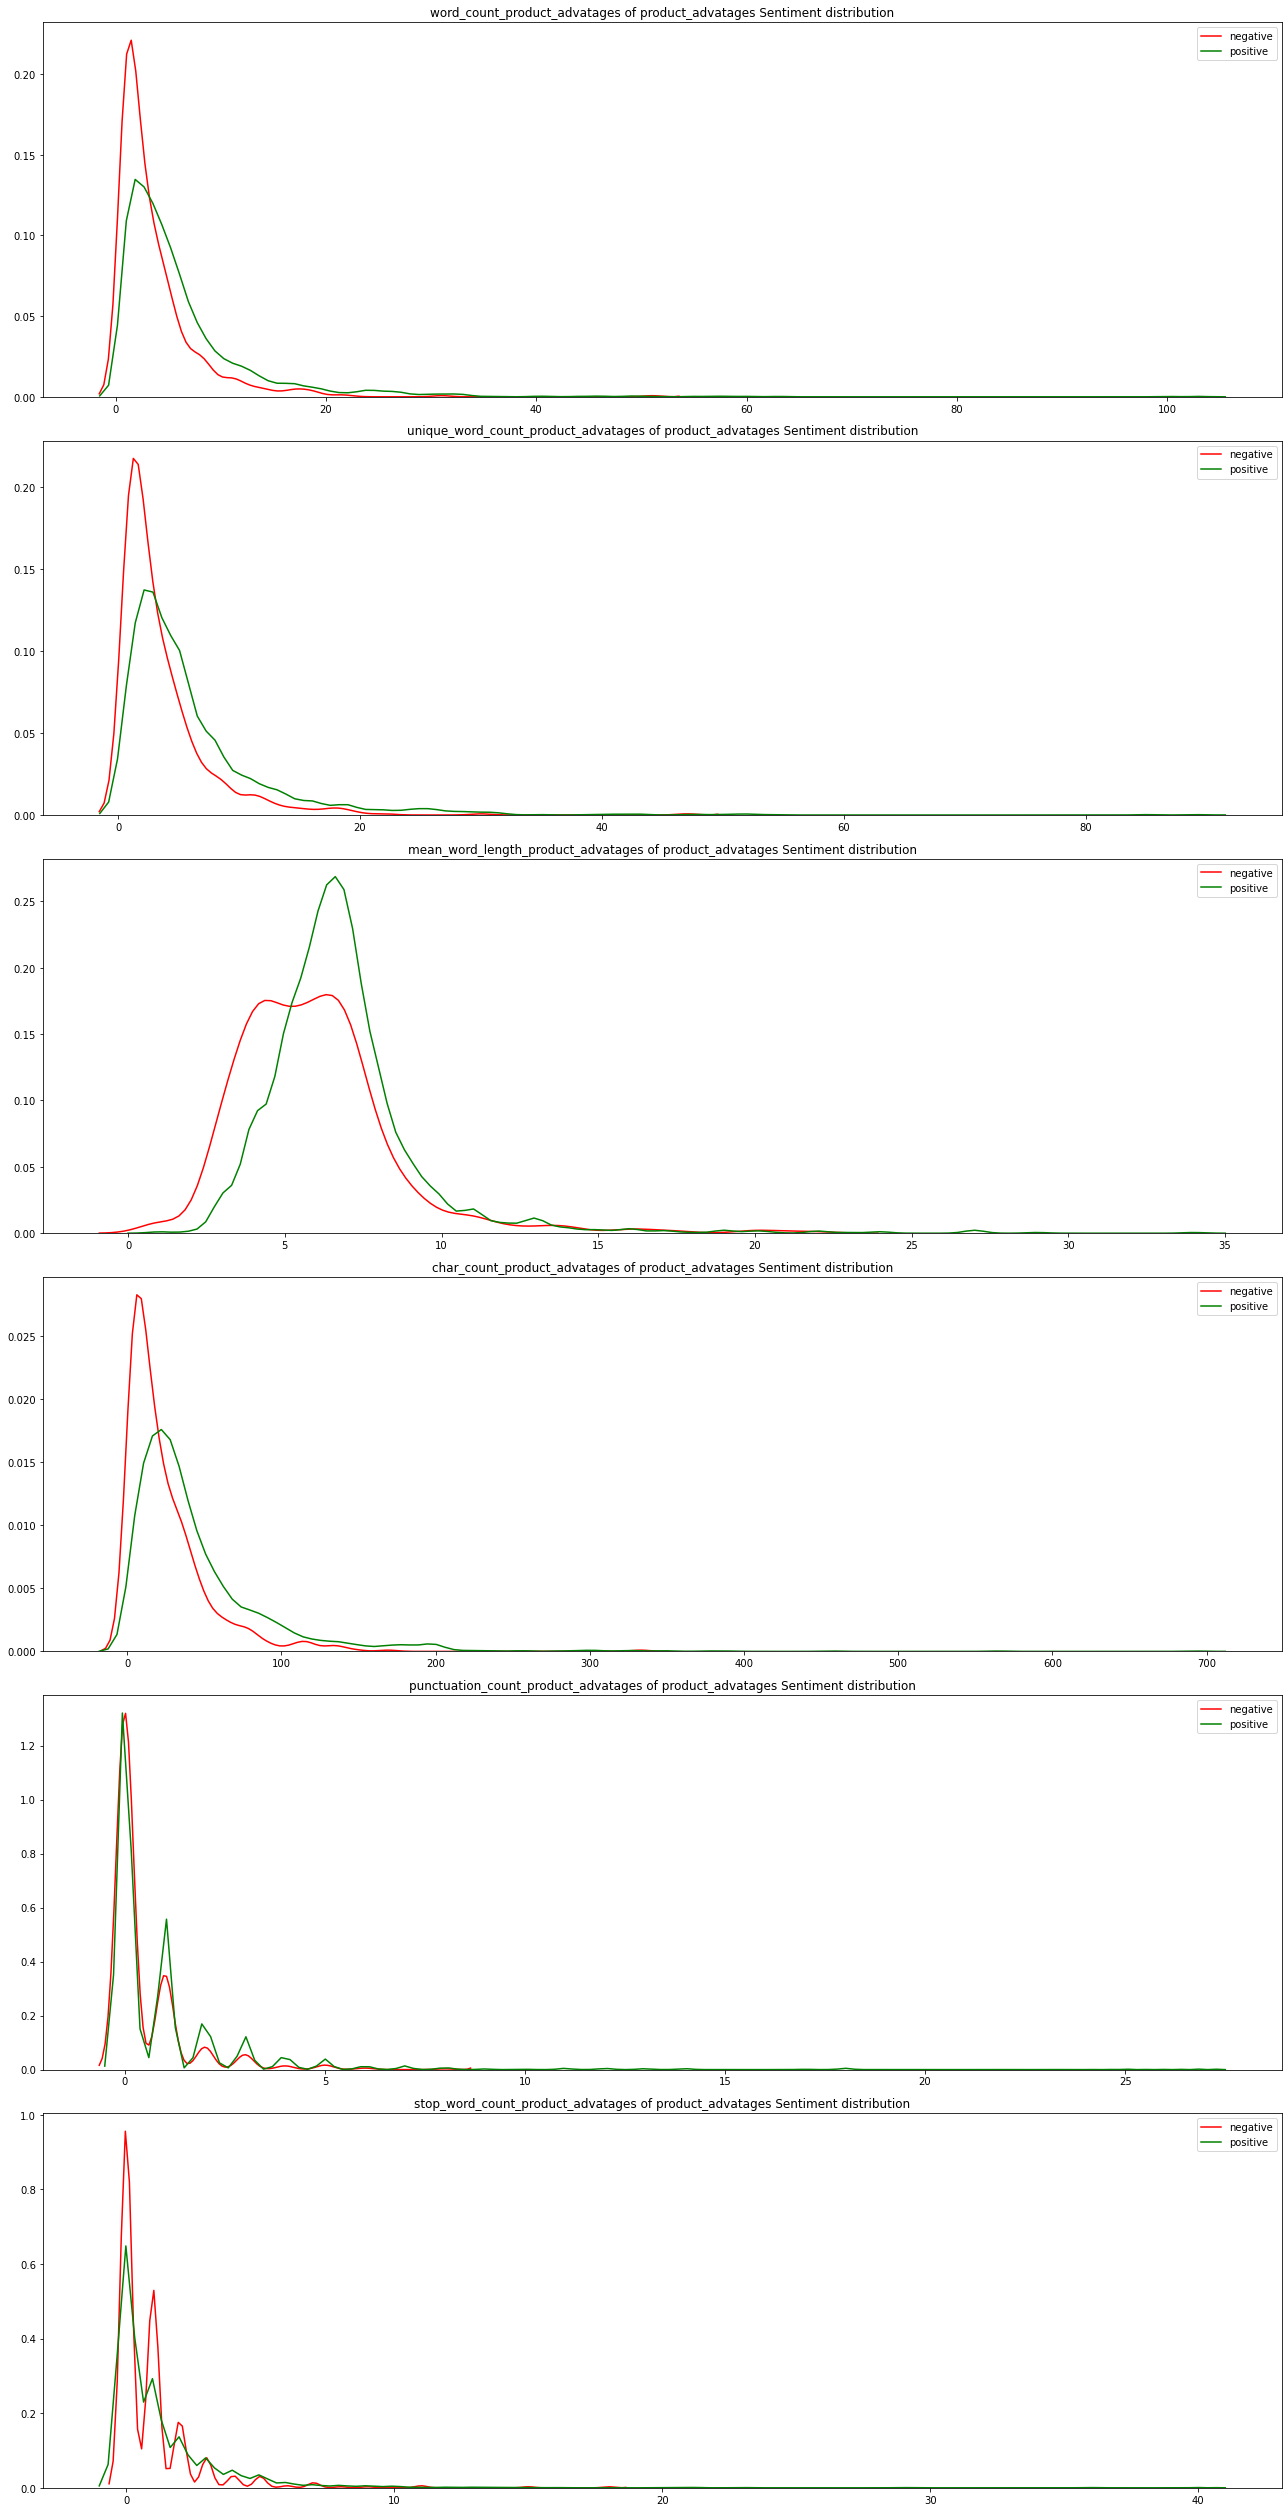

In [33]:
#Lets remove rows with empty product_advatages and calculate meta features
product_advatages_clean = pd.DataFrame(data_wth_rating.dropna(subset = ['product_advatages']))

#Calculate Meta Features of product_advatages using function calculate_meta_features
calculate_meta_features(product_advatages_clean, 'product_advatages')

#Plot meta features distribution in relation to  simplified Target variable - Review rating
fig, axes = plt.subplots(6, figsize=(18,35))
for count, column in enumerate(['word_count_product_advatages', 'unique_word_count_product_advatages', 'mean_word_length_product_advatages', 'char_count_product_advatages', 'punctuation_count_product_advatages', 'stop_word_count_product_advatages']):
    sns.kdeplot(ax = axes[count], data=product_advatages_clean[product_advatages_clean['review_sentiment'] == '0'][column], shade=False, color='red', label ='negative')
    sns.kdeplot(ax = axes[count], data=product_advatages_clean[product_advatages_clean['review_sentiment'] == '1'][column], shade=False, color='green', label ='positive')
    axes[count].set_title('{} of product_advatages Sentiment distribution'.format(column))
fig.tight_layout()

*Distributions of majority of meta features are different for negative and positive reviews. punctuation_count and stop_word_count might be not good enough, but other features can be helpful in modeling stage.*

##  product_disadvantages - Meta Features analysis 

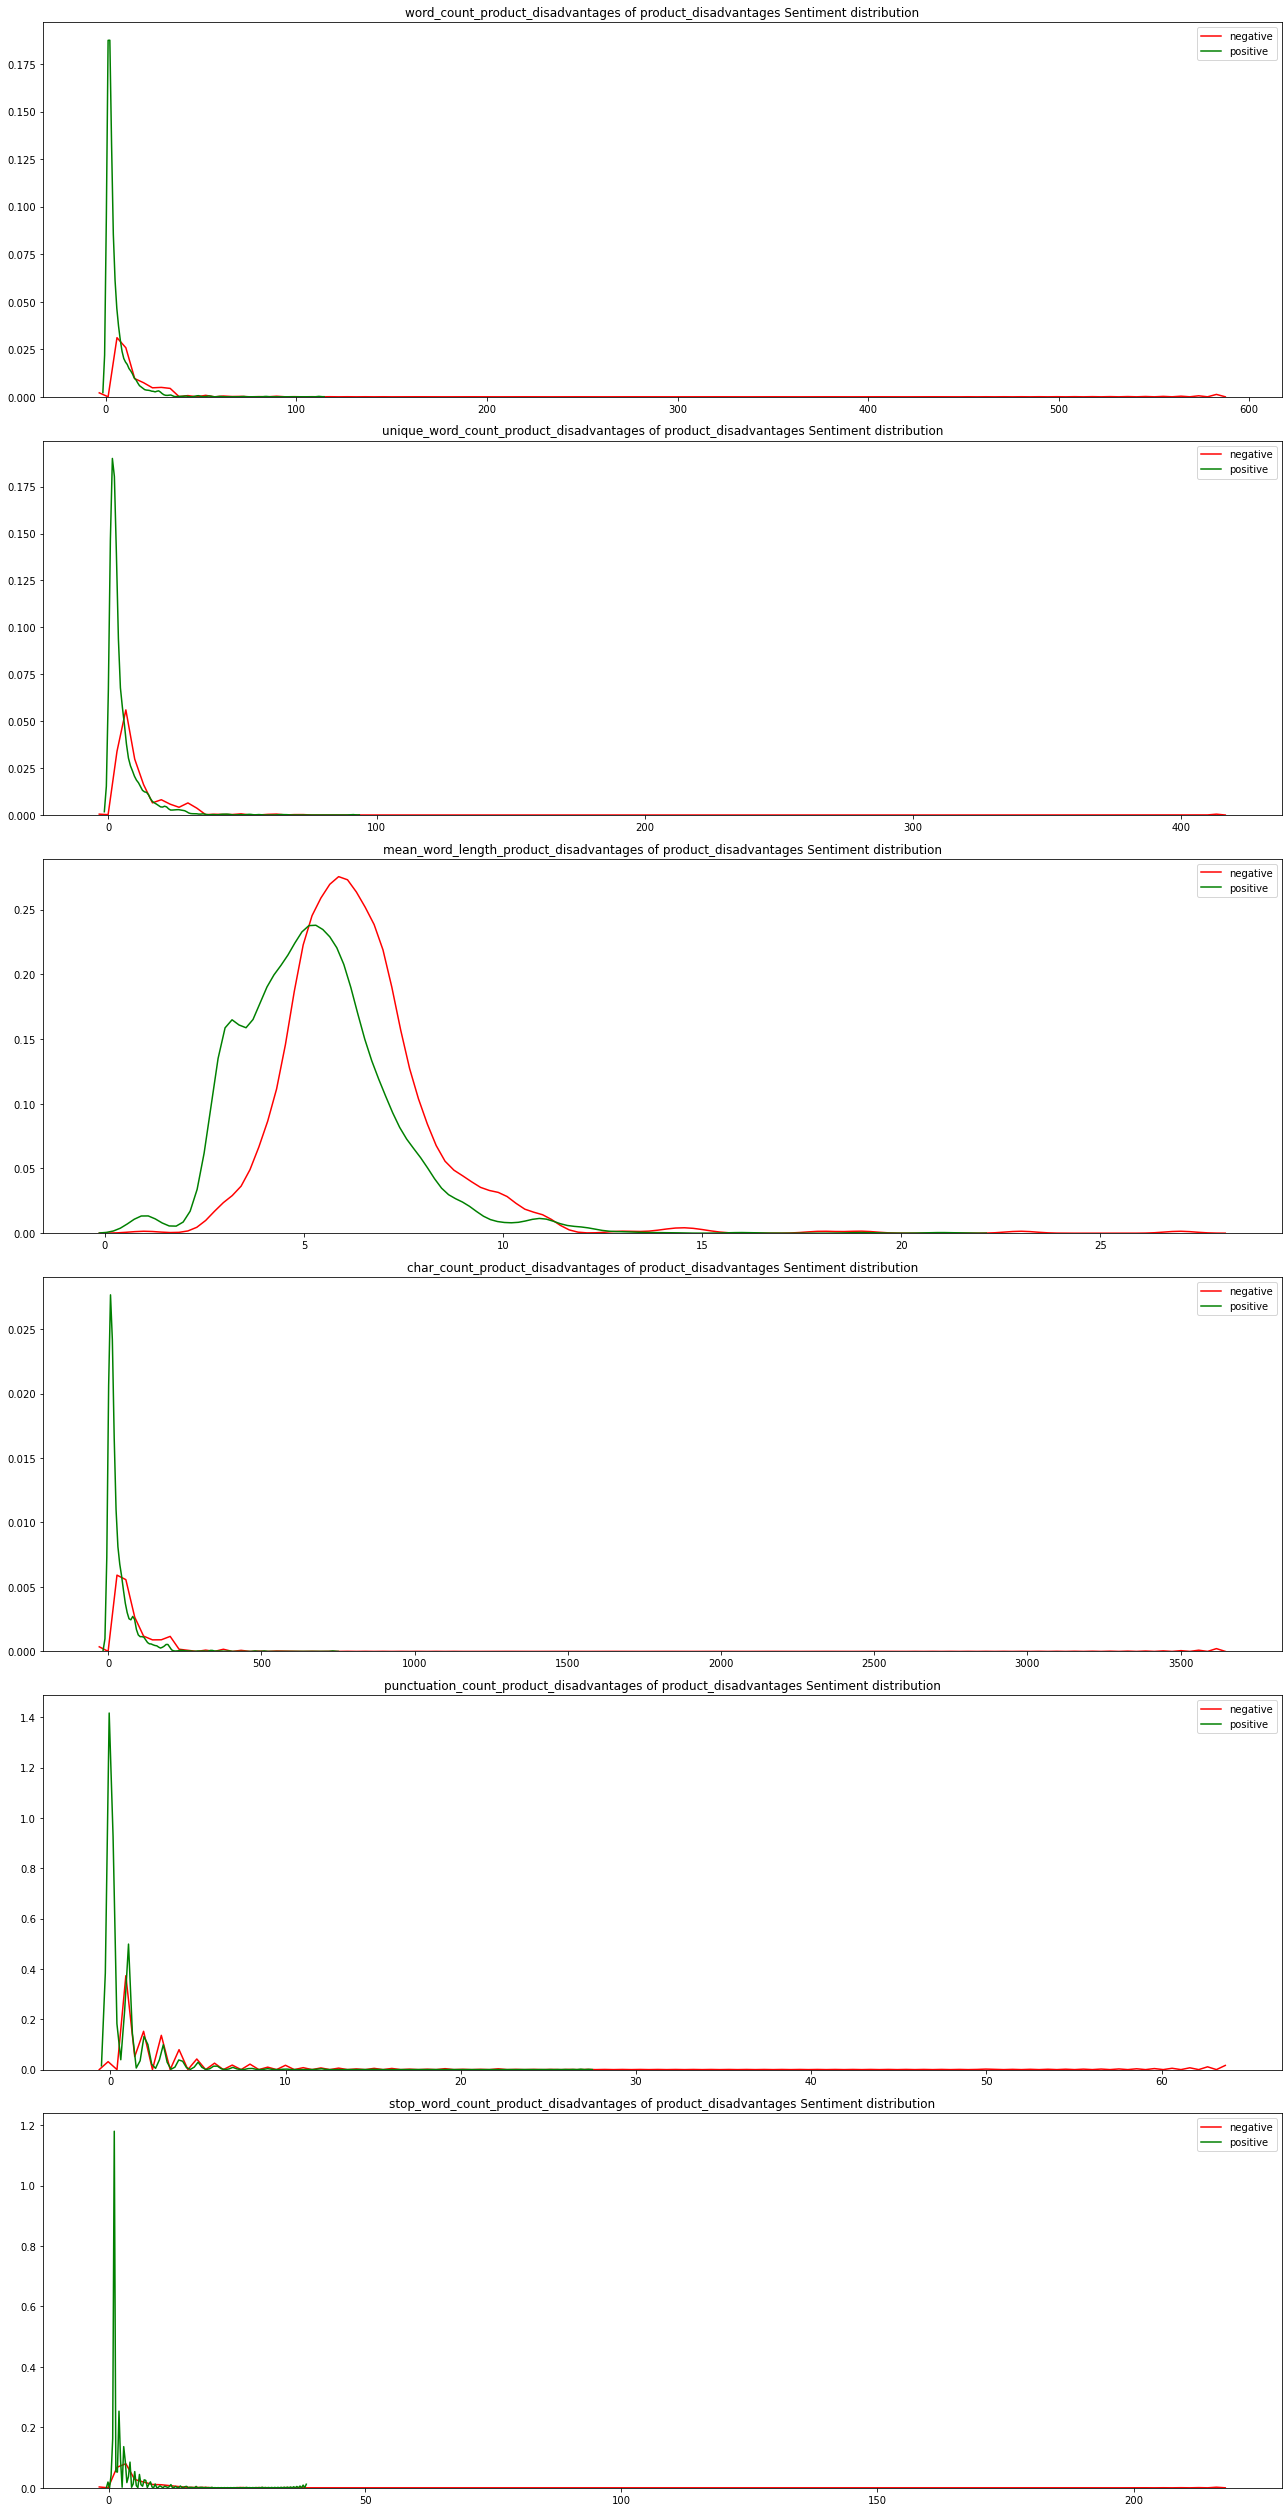

In [34]:
#Lets remove rows with empty product_disadvantages and calculate meta features
product_disadvantages_clean = pd.DataFrame(data_wth_rating.dropna(subset = ['product_disadvantages']))

#Calculate Meta Features of product_disadvantages using function calculate_meta_features
calculate_meta_features(product_disadvantages_clean, 'product_disadvantages')

#Plot meta features distribution in ralation to  simplified Target variable - Review rating
fig, axes = plt.subplots(6, figsize=(18,35))
for count, column in enumerate(['word_count_product_disadvantages', 'unique_word_count_product_disadvantages', 'mean_word_length_product_disadvantages', 'char_count_product_disadvantages', 'punctuation_count_product_disadvantages', 'stop_word_count_product_disadvantages']):
    sns.kdeplot(ax = axes[count], data=product_disadvantages_clean[product_disadvantages_clean['review_sentiment'] == '0'][column], shade=False, color='red', label ='negative')
    sns.kdeplot(ax = axes[count], data=product_disadvantages_clean[product_disadvantages_clean['review_sentiment'] == '1'][column], shade=False, color='green', label ='positive')
    axes[count].set_title('{} of product_disadvantages Sentiment distribution'.format(column))
fig.tight_layout()

*Distributions of all meta features are different for negative and positive reviews. These features can be helpful in modeling stage.*

# Step 3: Biulding prediction model with BERT

For this project of text classification by predicting review sentiment it’s suggested to use the BERT model (Bidirectional Encoder Representations from Transformers).

Nowadays it is a very popular model which currently provides outstanding results in text processing because of it bidirectional approach and allows to have a deeper sense of language context and flow than single-direction language models. 

To build the model we will use Ktrain - a lightweight wrapper for TensorFlow.Keras and many other libraries, which will allow to use state-of-the-art machine learning model with much fewer coding required.

## Preprocessing: Drop rows with missing values

In [19]:
#Drop rows without rating to train the model on labels data
data_clean = data.dropna(subset = ['review_rating'])

#Drop rows without review_text, product_advatages, product_disadvantages as for these rows we don't have enough information to make prediction
data_clean = data_clean.dropna(subset = ['full_text'])

data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3807 entries, 1 to 5104
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   comment_link           3807 non-null   object        
 1   product_title          3807 non-null   object        
 2   product_price          3807 non-null   float64       
 3   review_id              3807 non-null   int64         
 4   review_date            3807 non-null   datetime64[ns]
 5   review_text            3752 non-null   object        
 6   review_rating          3807 non-null   float64       
 7   thumbs_up              3807 non-null   int64         
 8   thumbs_down            3807 non-null   int64         
 9   product_advatages      2912 non-null   object        
 10  product_disadvantages  2831 non-null   object        
 11  full_text              3807 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory u

In [20]:
#Check rows with empty review_text, product_advatages, product_disadvantages   
data_clean[data_clean.review_text.isna()&(data_clean.product_advatages.isna()&data_clean.product_disadvantages.isna())]

Empty DataFrame
Columns: [comment_link, product_title, product_price, review_id, review_date, review_text, review_rating, thumbs_up, thumbs_down, product_advatages, product_disadvantages, full_text]
Index: []

In [21]:
#Check rows with empty review text, but not empty product_advatages, product_disadvantages to see if there is enough information for model training
data_clean[data_clean.review_text.isna()&(data_clean.product_advatages.notna()|data_clean.product_disadvantages.notna())]

comment_link  \
69    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48625332           
256   https://rozetka.com.ua/ua/motorola_page0015rs/p245661253/comments/#id=49338573                        
390   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_3_64gb_midnight_grey/p209754337/comments/#id=49217106   
821   https://rozetka.com.ua/ua/apple_mhdm3/p260937056/comments/#id=49268094                                
1291  https://rozetka.com.ua/ua/meizu_m6t_2_16gb_black_106738/p111954806/comments/#id=45315357              
1301  https://rozetka.com.ua/ua/vivo_y1s_2_32gb_black/p237030031/comments/#id=49385707                      
1944  https://rozetka.com.ua/ua/71671101/p71671101/comments/#id=44725464                                    
1959  https://rozetka.com.ua/ua/55904076/p55904076/comments/#id=39592455                                    
1975  https://rozetka.com.ua/ua/28782137/p28782137/comments/#id=36964164                                    
2105  https://rozetka.com.ua/ua/samsung_galaxy_m31_6_128gb_blue/p175401451/comments/#id=46321174            
2182  https://rozetka.com.ua/ua/apple_iphone_11_pro_max_64gb_space_gray/p137227775/comments/#id=46893508    
2224  https://rozetka.com.ua/ua/nokia_2_3_2_32gb_black/p159096638/comments/#id=48945253                     
2226  https://rozetka.com.ua/ua/nokia_2_3_2_32gb_black/p159096638/comments/#id=48889811                     
2437  https://rozetka.com.ua/ua/apple_iphone_11_pro_64gb_space_gray/p135813894/comments/#id=49023157        
2618  https://rozetka.com.ua/ua/realme_c3_2_32gb_blue/p210636577/comments/#id=48575739                      
2715  https://rozetka.com.ua/ua/2e_e450a_2018_dualsim_black/p51927996/comments/#id=47338989                 
2864  https://rozetka.com.ua/ua/huawei_p30_aurora/p76639638/comments/#id=47152986                           
3286  https://rozetka.com.ua/ua/tecno_camon_12_air_cc6_bay_blue/p142151745/comments/#id=46593624            
3363  https://rozetka.com.ua/ua/zte_blade_v10_vita_3_64gb_green/p99194710/comments/#id=44621698             
3365  https://rozetka.com.ua/ua/assistant_as_502_shot_black/p32105951/comments/#id=47310010                 
3443  https://rozetka.com.ua/ua/zte_blade_a5_2_32gb_black/p213750829/comments/#id=47209280                  
3587  https://rozetka.com.ua/ua/tecno_pouvoir_2_la7_pro_gold/p55399962/comments/#id=44433797                
3627  https://rozetka.com.ua/ua/prestigio_psp3515duoblack/p63313990/comments/#id=49209761                   
3633  https://rozetka.com.ua/ua/tecno_4895180747427/p102580422/comments/#id=48492587                        
3649  https://rozetka.com.ua/ua/doogee_y7_obsidian_black/p70934534/comments/#id=46589710                    
3753  https://rozetka.com.ua/ua/impression_imsmart_c571/p18132564/comments/#id=44549436                     
4096  https://rozetka.com.ua/ua/117931855/p117931855/comments/#id=44547856                                  
4234  https://rozetka.com.ua/ua/xiaomi_redmi_note_9s_6_128gb_grey/p204698749/comments/#id=46321211          
4301  https://rozetka.com.ua/ua/107415330/p107415330/comments/#id=44220887                                  
4421  https://rozetka.com.ua/ua/71671107/p71671107/comments/#id=45431142                                    
4433  https://rozetka.com.ua/ua/55909158/p55909158/comments/#id=44741136                                    
4436  https://rozetka.com.ua/ua/55909158/p55909158/comments/#id=45008030                                    
4510  https://rozetka.com.ua/ua/68057099/p68057099/comments/#id=45355356                                    
4593  https://rozetka.com.ua/ua/51610266/p51610266/comments/#id=35848512                                    
4674  https://rozetka.com.ua/ua/91537100/p91537100/comments/#id=44379522                                    
4721  https://rozetka.com.ua/ua/73796121/p73796121/comments/#id=44700828                                    
4984  https://rozetka.com.ua/ua/66806117/p66806117/comments/

*From table above we see that majority of records with empty review_text have useful information in product_advatages, product_disadvantages columns, so we will keep these recods*

## Preprocessing: Preparation of target variable 

We will train a model to predict sentiment of review based on it's text. Target variable (review sentiment) will be calculated based on review_rating column:
- positive sentiment will have the value “1” and correspond to rating of 4 and 5 stars;
- negative sentiment will have the value “0” and correspond to rating of 1, 2 and 3 stars.

In [22]:
#Create new column review_sentiment for target variable
data_clean.loc[(data_clean['review_rating']==1)|(data_clean['review_rating']==2)|(data_clean['review_rating']==3), 'review_sentiment'] = '0' 
data_clean.loc[(data_clean['review_rating']==4)|(data_clean['review_rating']==5), 'review_sentiment'] = '1'
display(data_clean.review_sentiment.head())

1    0
2    0
5    0
6    0
8    1
Name: review_sentiment, dtype: object

In [23]:
#Check proportions of negative and positive reviews
display(round(data_clean.groupby('review_sentiment')['comment_link'].count()/data_clean.shape[0], 2))

review_sentiment
0    0.23
1    0.77
Name: comment_link, dtype: float64

*Class distribution of target variable is imbalanced, 77% of all reviews are positive.*

In [24]:
# Write created cleaned DaraFrame to csv file for easier access to prepared data for training models
data_clean.to_csv('data_clean.csv', index=False)

In [25]:
#Encode target variable (format required for the modeling)
target = pd.get_dummies(data_clean.review_sentiment)
data_clean['0'] = target.iloc[:, 0]
data_clean['1'] = target.iloc[:, 1]

## Preprocessing: train/test split and preprocessing pipeline with Bert mode

For training the model we will use the column full_text which contains all text from reviews (review_text, product_advatages, product_disadvantages). 

In [26]:
#Split dataset into training and test. Test dataframe can be used later to check model performance on the unseen data.
#Add stratify parameter to ensure the same proportions of examples in each class as observed in the original dataset.
df_train, df_test = train_test_split(data_clean, test_size=0.2, stratify=data_clean.review_sentiment)

In [27]:
#Check proportions of examples in each class for training and test dataset.
display(round(df_test.groupby('review_sentiment')['review_id'].count()/df_test.shape[0], 2))
display(round(df_train.groupby('review_sentiment')['review_id'].count()/df_train.shape[0], 2))

review_sentiment
0    0.23
1    0.77
Name: review_id, dtype: float64

review_sentiment
0    0.23
1    0.77
Name: review_id, dtype: float64

In [28]:
#Data preprocessing with bert mode
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df_train, 
                                                                   'full_text', # name of column containing review text
                                                                   label_columns=['0', '1'],
                                                                   maxlen=200, 
                                                                   max_features=100000,
                                                                   preprocess_mode='bert',
                                                                   val_pct=0.1)

preprocessing train...
language: ru


Is Multi-Label? False
preprocessing test...
language: ru


## Building Bert model with ktrain

In [29]:
#Initializing pre-trained Bert model
model = text.text_classifier(name='bert',
                             train_data=(x_train, y_train),
                             preproc=preproc)

Is Multi-Label? False
maxlen is 200
done.


In [30]:
#View loaded model architecture summary
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 200)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 200, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 200, 768)     1536        Input-Segment[0][0]              
_______________________________________________________________________________________

In [31]:
#Wrap the model and data in a Learner object
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6)

In [47]:
#Run Learning Rate Finder
#learner.lr_find(max_epochs=1)

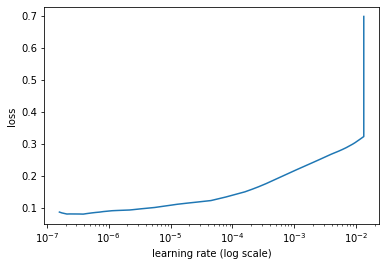

In [354]:
#Visually inspect the loss plot 
#learner.lr_plot() 

**Learning Rate Finder**
The Learner object can be used to find a good learning rate for the model using the lr_find and lr_plot methods. The lr_find method simulates training at different learning rates and tracks the loss. After visually inspecting the plot generated by lr_plot, we choose the highest learning rate still associated with the smallest loss - 1e-5

In [32]:
#Set learner to use default weight decay rate 
learner.get_weight_decay()
learner.set_weight_decay()

C:\Users\Anna\anaconda3\lib\site-packages\ktrain\core.py:357: UserWarning: recompiling model to use AdamWeightDecay as opimizer with weight decay of 0.01
  warnings.warn('recompiling model to use AdamWeightDecay as opimizer with weight decay of %s' % (wd) )


**Weight decay** 
Weight decay is a form of regularization, we will use it in order to reduce overfitting caused by target classes imbalance.
By default, ktrain uses no weight decay, but for our model we will set default weight decay rate of 0.01 implemented using the AdamWeightDecay optimizer.

In [49]:
#Create TensorBoard calback to use it later to analyse model performance
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='/tmp/Tensor_Board', histogram_freq=0, write_graph=True, write_images=True)

#Training the model
learner.fit_onecycle(lr=1e-5,
                     epochs=3,
                    callbacks=[tbCallBack])



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/3
457/457 [==============================] - 3156s 7s/step - loss: 0.4804 - accuracy: 0.7763 - val_loss: 0.3344 - val_accuracy: 0.8557
Epoch 2/3
457/457 [==============================] - 3255s 7s/step - loss: 0.3258 - accuracy: 0.8566 - val_loss: 0.2951 - val_accuracy: 0.8754
Epoch 3/3
457/457 [==============================] - 3363s 7s/step - loss: 0.1730 - accuracy: 0.9332 - val_loss: 0.2759 - val_accuracy: 0.8984


In [51]:
#Save trained model
learner.save_model('sentiment_prediction')
learner.model.save_weights("sentiment_prediction")


# Step 4: Evaluating model performance

## Check model performance metrics on the Training dataset

In [33]:
#Load trained model
learner.model.load_weights('./models/sentiment_prediction')

In [53]:
#Check learner performance metrics
display(learner.validate())

              precision    recall  f1-score   support

           0       0.78      0.79      0.78        71
           1       0.94      0.93      0.93       234

    accuracy                           0.90       305
   macro avg       0.86      0.86      0.86       305
weighted avg       0.90      0.90      0.90       305



array([[ 56,  15],
       [ 16, 218]], dtype=int64)

*From the table above we can see that the model has pretty high accuracy – 90% of predictions were correct.
Predictions for positive reviews are more precise: 94% of all predicted reviews are truly positive and 93% of all positive reviews were detected correctly.*
*For negative reviews precision is less: only 78% of all predicted reviews are truly negative and 79% of all negative reviews were detected correctly.*
*From f1-score we can see that the model is pretty good at predicting positive reviews and works worse for predicting negative reviews which is expected due to class imbalance.*

In [54]:
#View 5 top losses of the model.
#Reviewing where model made mistakes can help to understand better how algorithm works and if anything can be improved in preprocessing stage. 
txt = learner.view_top_losses(n=5, preproc=preproc)

----------
id:64 | loss:4.45 | true:0 | pred:1)

[CLS] от ##ли ##чны ##и теле ##фон , но нет ##у г ##уг ##л се ##рве ##ра . не при ##вы ##чно , не у ##до ##бно пре ##им ##у ##щества : none . не ##до ##стат ##ки : none [SEP]
----------
id:229 | loss:3.8 | true:0 | pred:1)

[CLS] кит ##аи ##ски ##и де ##шев ##ы ##и теле ##фон . пока а ##и ##фон в ремонт ##е , по ##ид ##ет . пре ##им ##у ##щества : их нет . при ##сла ##ли с бит ##ыми п ##ик ##сел ##ями э ##к ##ран . . не ##до ##стат ##ки : none [SEP]
----------
id:10 | loss:3.68 | true:0 | pred:1)

[CLS] теле ##фон дуже ди ##вно себе пов ##оди ##ть , часто живе сам по собі , гл ##ючи ##ть . пре ##им ##у ##щества : де ##шев ##ии . не ##до ##стат ##ки : none [SEP]
----------
id:65 | loss:3.66 | true:0 | pred:1)

[CLS] в принцип ##е , не ##п ##ло ##хо ##и теле ##фон , но на фоне опыт ##а владения nok ##ia 5 . 3 , с ##ка ##жу , что nok ##ia 5 . 4 - это не э ##вол ##ю ##ция и труд ##но с ##каз ##ать . . . и даже не де ##града ##ция . . . это ш

*From reviewing records with the biggest loss, we can see that for all of them model predicted positive sentiment when true value was negative sentiment. 
Some of reviews contain contradicting information: positive and negative feedback which may be confusing for classification. Other reviews seem to be clearly negative but were wrongly classified as positive*

## Check model performance metrics on the Testing dataset

Test data set can be used to evaluate performance of the model on the unseen by model data. It will help to confirm model performance results and define if there are any overfitting issues.

In [55]:
#Get predictor 
predictor = ktrain.get_predictor(learner.model, preproc)

In [56]:
#Make predictions on the Test dataset
df_test_pred = pd.DataFrame(df_test)
df_test_pred['bert_prediction'] = [predictor.predict(i) for i in df_test.full_text]

In [57]:
#Check proportions of predicted class for test dataset.
display(round(df_test_pred.groupby('bert_prediction')['review_id'].count()/df_test_pred.shape[0], 2))

bert_prediction
0    0.19
1    0.81
Name: review_id, dtype: float64

In [58]:
#Check model perfomance merics
print("Accuracy score of model's predictions on test dataset is {}".format(round(accuracy_score(df_test_pred.review_sentiment, df_test_pred.bert_prediction), 2)))
print("Area Under the Receiver Operating Characteristic Curve on test dataset is {}. It means that there is a {}% chance that the model will be able to distinguish between positive and negative class for reviews.".format(round(roc_auc_score(df_test_pred.review_sentiment, df_test_pred.bert_prediction), 2),round(roc_auc_score(df_test_pred.review_sentiment, df_test_pred.bert_prediction)*100, 1)))

Accuracy score of model's predictions on test dataset is 0.87
Area Under the Receiver Operating Characteristic Curve on test dataset is 0.79. It means that there is a 79.3% chance that the model will be able to distinguish between positive and negative class for reviews.


In [59]:
#Check confusion matrix
display(pd.DataFrame(confusion_matrix(df_test_pred.review_sentiment, df_test_pred.bert_prediction), 
             columns=['Predicted class 0', 'Predicted class 1'],
            index=['True class 0', 'True class 1']))

Predicted class 0  Predicted class 1
True class 0  114                63               
True class 1  34                 551

*From confusion matrix above we can see the same situation as in training data set, on positive reviews model performing much better than on negative reviews.*

In [60]:
confusion_matrix_1 = pd.DataFrame(confusion_matrix(df_test_pred.review_sentiment, df_test_pred.bert_prediction, normalize='true'), 
             columns=['Predicted class 0', 'Predicted class 1'],
            index=['True class 0', 'True class 1'])
display(confusion_matrix_1)
print('Table above shows that {}% of all negative reviews and {}% of all positive reviews were detected correctly.'.format(round(confusion_matrix_1.iloc[0,0]*100, 1), round(confusion_matrix_1.iloc[1,1]*100,1)))

Predicted class 0  Predicted class 1
True class 0  0.644068           0.355932         
True class 1  0.058120           0.941880

Table above shows that 64.4% of all negative reviews and 94.2% of all positive reviews were detected correctly.


In [61]:
confusion_matrix_2 = pd.DataFrame(confusion_matrix(df_test_pred.review_sentiment, df_test_pred.bert_prediction, normalize='pred'), 
             columns=['Predicted class 0', 'Predicted class 1'],
            index=['True class 0', 'True class 1'])
display(confusion_matrix_2)
print("Table above shows that {}% of predictions as class 'negative' and {}% of predictions of class 'positive' were correct.".format(round(confusion_matrix_2.iloc[0,0]*100, 1), round(confusion_matrix_2.iloc[1,1]*100,1)))

Predicted class 0  Predicted class 1
True class 0  0.77027            0.102606         
True class 1  0.22973            0.897394

Table above shows that 77.0% of predictions as class 'negative' and 89.7% of predictions of class 'positive' were correct.


# Step 5: Predict sentiment for reviews without rating

In [62]:
#Drop recods without text
data_to_pred = data.dropna(subset = ['full_text'])
#Select records without rating
data_to_pred = data_to_pred[data_to_pred.review_rating.isna()]
data_to_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1898 entries, 0 to 5119
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   comment_link           1898 non-null   object        
 1   product_title          1898 non-null   object        
 2   product_price          1898 non-null   float64       
 3   review_id              1898 non-null   int64         
 4   review_date            1898 non-null   datetime64[ns]
 5   review_text            1841 non-null   object        
 6   review_rating          0 non-null      float64       
 7   thumbs_up              1898 non-null   int64         
 8   thumbs_down            1898 non-null   int64         
 9   product_advatages      820 non-null    object        
 10  product_disadvantages  868 non-null    object        
 11  full_text              1898 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory u

In [63]:
#Make predictions of sentiment for reviews without rating
data_to_pred['bert_prediction'] = [predictor.predict(i) for i in data_to_pred.full_text]

In [64]:
#Look at proportion of predicted negative and positive sentiments
display(round(data_to_pred.groupby('bert_prediction')['review_id'].count()/data_to_pred.shape[0], 2))

bert_prediction
0    0.33
1    0.67
Name: review_id, dtype: float64

In [65]:
display(data_to_pred.head(20))

comment_link  \
0   https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49293156   
7   https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49360716   
11  https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49395870                             
19  https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49342195                             
22  https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49366754                             
25  https://rozetka.com.ua/ua/apple_iphone_12_pro_max_128gb_silver/p245162461/comments/#id=49287407              
29  https://rozetka.com.ua/ua/apple_iphone_12_pro_max_128gb_silver/p245162461/comments/#id=49123777              
33  https://rozetka.com.ua/ua/apple_iphone_12_pro_max_128gb_silver/p245162461/comments/#id=49116680              
34  https://rozetka.com.ua/ua/apple_iphone_12_pro_max_128gb_silver/p245162461/comments/#id=49159463              
40  https://rozetka.com.ua/ua/samsung_sm_a025fzkesek/p268107536/comments/#id=49390694                            
43  https://rozetka.com.ua/ua/samsung_sm_a025fzkesek/p268107536/comments/#id=49350462                            
55  https://rozetka.com.ua/ua/samsung_sm_a315fzwvsek/p199478977/comments/#id=49384061                            
64  https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=49396807                  
70  https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48857432                  
73  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49300772                 
75  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49297066                 
76  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49268051                 
81  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49311850                 
83  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49291997                 
86  https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=49272310                            

                                                                                                                  product_title  \
0    Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
7    Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
11   Мобільний телефон Samsung Galaxy A71 6/128GB Blue (SM-A715FZBUSEK)                                                           
19   Мобільний телефон Samsung Galaxy A71 6/128GB Blue (SM-A715FZBUSEK)                                                           
22   Мобільний телефон Samsung Galaxy A71 6/128GB Blue (SM-A715FZBUSEK)                                                           
25   Мобільний телефон Apple iPhone 12 Pro Max 128 GB Silver Офіційна гарантія                                                    
29   Мобільний телефон Apple iPhone 12 Pro Max 128 GB Silver Офіційна гарантія                                                    
33   Мобільний телефон Apple iPhone 12 Pro Max 128 GB Silver Офіційна гарантія                                                    
34   Мобільний телефон Apple iPhone 12 Pro Max 128 GB Silver Офіційна гарантія                                                    
40   Мобільний телефон Samsung Galaxy A02s 3/32 GB Black (SM-A025FZKESEK)                                                         
43   Мобільний телефон Samsung Galaxy A02s 3/32 GB Black (SM-A025FZKESEK)                                                         
55   Мобільний телефон Samsung Galaxy A31 4/128GB Prism Crush White (SM-A315FZWVSEK)                                              


I would categorize 20 records in the table above the following way:
-	Questions/orders -  2 records,
-	Only feedback about shop/service – 3 records,
-	Reviews and feedback about product – 15 records (among these records I would say that 7 recodes are confusing, but it’s still possible to identify sentiment and 8 records contain more or less constructive feedback).
It’s important to pay attention that initial data contains information about feedback about product, about shop/service and just questions. While applying model to solve a task or answer a question it may be useful to filter initial data first to get records that actually contain information related to subject of interest.

By manually classifying 20 displayed records to positive/negative sentiment, I would agree with 13 predictions and choose different sentiment in 8 records (all errors are flase positive), it gives accuracy of 60%. 

In [66]:
display(data_to_pred.tail(20))

comment_link  \
2474  https://rozetka.com.ua/ua/nokia_1_3_1_16gb_dualsim_charcoal/p197525707/comments/#id=49386107       
2489  https://rozetka.com.ua/ua/xiaomi_mi_10t_lite_6_128gb_pearl_gray/p252721136/comments/#id=49405897   
2491  https://rozetka.com.ua/ua/xiaomi_mi_10t_lite_6_128gb_pearl_gray/p252721136/comments/#id=49595895   
2532  https://rozetka.com.ua/ua/huawei_nova_5t_crush_blue/p149442588/comments/#id=49406579               
2537  https://rozetka.com.ua/ua/huawei_nova_5t_crush_blue/p149442588/comments/#id=49602258               
2555  https://rozetka.com.ua/ua/nokia_2_3_2_32gb_black/p159096638/comments/#id=49480378                  
2687  https://rozetka.com.ua/ua/vivo_y15_4_64gb_aqua_blue/p104968494/comments/#id=49459980               
2730  https://rozetka.com.ua/ua/xiaomi_765959/p282452478/comments/#id=49777611                           
2744  https://rozetka.com.ua/ua/xiaomi_mi_note_10_lite_6_64gb_purple/p210765661/comments/#id=48438761    
2750  https://rozetka.com.ua/ua/xiaomi_mi_note_10_lite_6_64gb_purple/p210765661/comments/#id=48146024    
2829  https://rozetka.com.ua/ua/meizu_16_6_128gb_black/p154385183/comments/#id=48750534                  
2890  https://rozetka.com.ua/ua/huawei_p_smart_pro_6_128_black/p145141992/comments/#id=49664266          
3023  https://rozetka.com.ua/ua/sony_xperia_l1_290742/p15285049/comments/#id=49816723                    
3175  https://rozetka.com.ua/ua/zte_blade_v10_vita_3_64gb_green/p99194710/comments/#id=49790626          
3225  https://rozetka.com.ua/ua/tp_link_neffos_tp7071a55ua/p106788753/comments/#id=49756783              
3261  https://rozetka.com.ua/ua/tp_link_tp7061a54ua/p127608821/comments/#id=49515093                     
3300  https://rozetka.com.ua/ua/tp_link_neffos_tp7051_red/p111538058/comments/#id=49679005               
3448  https://rozetka.com.ua/ua/tp_link_neffos_c7_tp910a24ua/p32644807/comments/#id=49400578             
4244  https://rozetka.com.ua/ua/39171344/p39171344/comments/#id=39705060                                 
5119  https://rozetka.com.ua/ua/sony_xperia_1_ii_black/p189372940/comments/#id=46619100                  

                                                                     product_title  \
2474   Мобільний телефон Nokia 1.3 1/16 GB DualSim Charcoal                          
2489   Мобільний телефон Xiaomi Mi 10T Lite 6/128 GB Pearl Gray                      
2491   Мобільний телефон Xiaomi Mi 10T Lite 6/128 GB Pearl Gray                      
2532   Мобільний телефон Huawei Nova 5T Crush Blue                                   
2537   Мобільний телефон Huawei Nova 5T Crush Blue                                   
2555   Мобільний телефон Nokia 2.3 2/32GB Charcoal                                   
2687   Мобільний телефон Vivo Y15 4/64GB Aqua Blue                                   
2730   Мобільний телефон Xiaomi Redmi Note 10 Pro 6/64GB Gradient Bronze (765959)    
2744   Мобільний телефон Xiaomi Mi Note 10 Lite 6/64GB Purple                        
2750   Мобільний телефон Xiaomi Mi Note 10 Lite 6/64GB Purple                        
2829   Мобільний телефон Meizu 16 6/128GB Black                                      
2890   Мобільний телефон Huawei P Smart Pro 6/128GB Black                            
3023   Мобільний телефон Sony Xperia L1 Dual (G3312) Pink                            
3175   Мобільний телефон ZTE Blade V10 Vita 3/64GB Green                             
3225   Мобільний телефон TP-Link Neffos X20 Black                                    
3261   Мобільний телефон TP-Link Neffos C9s (TP7061A54UA) Dark Blue                  
3300   Мобільний телефон TP-Link Neffos C7s (TP7051) Red                             
3448   Мобільний телефон TP-Link Neffos C7 (TP910A24UA) Cloudy Grey                  
4244   Смартфон Vivo X20 4/64GB Black Matte                                          
5119   Мобільний телефон Sony Xperia 1 II Black                                      

      product_price  review_id review_date  \
2474  1999

I would categorize 20 records in the table above the following way:
-	Questions/orders -  1 record,
-	Only feedback about shop/service – 4 records,
-	Reviews and feedback about product – 15 records (among these records I would say that 3 recodes are confusing, but it’s still possible to identify sentiment and 12 records contain more or less constructive feedback).

By manually classifying 20 displayed records to positive/negative sentiment, I would agree with 13 predictions, choose different sentiment in 7 records (6 predictions are false positive 1 false negative) and 1 records is hard to classify.
If we don't include review that is hard to classify as wrong prediction, accuracy will be 65%

Received results are not so good, so let’s if explore if it’s possible to improve the performance.

# Step 6: Building BERT model v2: oversample negative class to remove class imbalance in target variable

This step was performed in the separate script "Build_Bert_model_v2.ipynb"

# Step 7: Running BERT model v2 and evaluating model performance

To improve the model performance, it was decided to make an experiment: to oversample negative reviews, so there are the same number of positive and negative reviews in the training set, this will remove bias and allow model to learn more about negative class.
Preparation of the new training set with uniform classes distribution and training the model was done in the separate script.

In [34]:
#Load trained model
#learner.load_model('sentiment_prediction_2_3epochs', preproc=preproc)
learner.model.load_weights("./models/sentiment_prediction_v2")

## Check model performance metrics on the Training dataset

In [68]:
#Check learner performance metrics
display(learner.validate())

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        71
           1       1.00      0.97      0.98       234

    accuracy                           0.97       305
   macro avg       0.95      0.98      0.96       305
weighted avg       0.98      0.97      0.97       305



array([[ 70,   1],
       [  7, 227]], dtype=int64)

*From the table above we can see that the model has pretty high accuracy – 97% of predictions were correct.
Predictions for positive reviews are more precise: 100% of all predicted reviews are truly positive and 97% of all positive reviews were detected correctly.*
*For negative reviews precision is a bit less: 91% of all predicted reviews are truly negative and 99% of all negative reviews were detected correctly.*
*From f1-score we can see that the model is doing well at predicting positive and negative reviews. Seems like experiment with oversampling negative class gave a significant improvemnt.*

## Check model performance metrics on the Testing dataset

In [69]:
#Get predictor 
predictor = ktrain.get_predictor(learner.model, preproc)
#Make predictions on the Test dataset
df_test_pred = pd.DataFrame(df_test)
df_test_pred['bert_prediction'] = [predictor.predict(i) for i in df_test.full_text]

In [70]:
#Check proportions of predicted class for test dataset.
display(round(df_test_pred.groupby('bert_prediction')['review_id'].count()/df_test_pred.shape[0], 2))

bert_prediction
0    0.24
1    0.76
Name: review_id, dtype: float64

In [84]:
#Check model perfomance merics
print("Accuracy score of model's predictions on test dataset is {}".format(round(accuracy_score(df_test_pred.review_sentiment, df_test_pred.bert_prediction), 2)))
print("Area Under the Receiver Operating Characteristic Curve on test dataset is {}. It means that there is a {}% chance that the model will be able to distinguish between positive and negative class for reviews.".format(round(roc_auc_score(df_test_pred.review_sentiment, df_test_pred.bert_prediction), 4),round(roc_auc_score(df_test_pred.review_sentiment, df_test_pred.bert_prediction)*100, 1)))

Accuracy score of model's predictions on test dataset is 0.98
Area Under the Receiver Operating Characteristic Curve on test dataset is 0.9773. It means that there is a 97.7% chance that the model will be able to distinguish between positive and negative class for reviews.


In [72]:
confusion_matrix_1 = pd.DataFrame(confusion_matrix(df_test_pred.review_sentiment, df_test_pred.bert_prediction, normalize='true'), 
             columns=['Predicted class 0', 'Predicted class 1'],
            index=['True class 0', 'True class 1'])
display(confusion_matrix_1)
print('Table above shows that {}% of all negative reviews and {}% of all positive reviews were detected correctly.'.format(round(confusion_matrix_1.iloc[0,0]*100, 1), round(confusion_matrix_1.iloc[1,1]*100,1)))

Predicted class 0  Predicted class 1
True class 0  0.971751           0.028249         
True class 1  0.017094           0.982906

Table above shows that 97.2% of all negative reviews and 98.3% of all positive reviews were detected correctly.


In [73]:
confusion_matrix_2 = pd.DataFrame(confusion_matrix(df_test_pred.review_sentiment, df_test_pred.bert_prediction, normalize='pred'), 
             columns=['Predicted class 0', 'Predicted class 1'],
            index=['True class 0', 'True class 1'])
display(confusion_matrix_2)
print("Table above shows that {}% of predictions as class 'negative' and {}% of predictions of class 'positive' were correct.".format(round(confusion_matrix_2.iloc[0,0]*100, 1), round(confusion_matrix_2.iloc[1,1]*100,1)))

Predicted class 0  Predicted class 1
True class 0  0.945055           0.008621         
True class 1  0.054945           0.991379

Table above shows that 94.5% of predictions as class 'negative' and 99.1% of predictions of class 'positive' were correct.


## Predict sentiment for reviews without rating with Bert model v2

In [74]:
#Drop recods without text
data_to_pred = data.dropna(subset = ['full_text'])
#Select records without rating
data_to_pred = data_to_pred[data_to_pred.review_rating.isna()]
data_to_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1898 entries, 0 to 5119
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   comment_link           1898 non-null   object        
 1   product_title          1898 non-null   object        
 2   product_price          1898 non-null   float64       
 3   review_id              1898 non-null   int64         
 4   review_date            1898 non-null   datetime64[ns]
 5   review_text            1841 non-null   object        
 6   review_rating          0 non-null      float64       
 7   thumbs_up              1898 non-null   int64         
 8   thumbs_down            1898 non-null   int64         
 9   product_advatages      820 non-null    object        
 10  product_disadvantages  868 non-null    object        
 11  full_text              1898 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory u

In [75]:
#Make predictions of sentiment for reviews without rating
data_to_pred['bert_prediction'] = [predictor.predict(i) for i in data_to_pred.full_text]

In [76]:
#Look at proportion of predicted negative and positive sentiments
display(round(data_to_pred.groupby('bert_prediction')['review_id'].count()/data_to_pred.shape[0], 2))

bert_prediction
0    0.41
1    0.59
Name: review_id, dtype: float64

The model predicts quite big proportion of negative sentiment reviews among unrated records.  

In [77]:
# Let's look at top 20 predictions
display(data_to_pred.head(20))

comment_link  \
0   https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49293156   
7   https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49360716   
11  https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49395870                             
19  https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49342195                             
22  https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49366754                             
25  https://rozetka.com.ua/ua/apple_iphone_12_pro_max_128gb_silver/p245162461/comments/#id=49287407              
29  https://rozetka.com.ua/ua/apple_iphone_12_pro_max_128gb_silver/p245162461/comments/#id=49123777              
33  https://rozetka.com.ua/ua/apple_iphone_12_pro_max_128gb_silver/p245162461/comments/#id=49116680              
34  https://rozetka.com.ua/ua/apple_iphone_12_pro_max_128gb_silver/p245162461/comments/#id=49159463              
40  https://rozetka.com.ua/ua/samsung_sm_a025fzkesek/p268107536/comments/#id=49390694                            
43  https://rozetka.com.ua/ua/samsung_sm_a025fzkesek/p268107536/comments/#id=49350462                            
55  https://rozetka.com.ua/ua/samsung_sm_a315fzwvsek/p199478977/comments/#id=49384061                            
64  https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=49396807                  
70  https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48857432                  
73  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49300772                 
75  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49297066                 
76  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49268051                 
81  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49311850                 
83  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49291997                 
86  https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=49272310                            

                                                                                                                  product_title  \
0    Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
7    Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
11   Мобільний телефон Samsung Galaxy A71 6/128GB Blue (SM-A715FZBUSEK)                                                           
19   Мобільний телефон Samsung Galaxy A71 6/128GB Blue (SM-A715FZBUSEK)                                                           
22   Мобільний телефон Samsung Galaxy A71 6/128GB Blue (SM-A715FZBUSEK)                                                           
25   Мобільний телефон Apple iPhone 12 Pro Max 128 GB Silver Офіційна гарантія                                                    
29   Мобільний телефон Apple iPhone 12 Pro Max 128 GB Silver Офіційна гарантія                                                    
33   Мобільний телефон Apple iPhone 12 Pro Max 128 GB Silver Офіційна гарантія                                                    
34   Мобільний телефон Apple iPhone 12 Pro Max 128 GB Silver Офіційна гарантія                                                    
40   Мобільний телефон Samsung Galaxy A02s 3/32 GB Black (SM-A025FZKESEK)                                                         
43   Мобільний телефон Samsung Galaxy A02s 3/32 GB Black (SM-A025FZKESEK)                                                         
55   Мобільний телефон Samsung Galaxy A31 4/128GB Prism Crush White (SM-A315FZWVSEK)                                              


*By manually classifying 20 displayed records to positive/negative sentiment, I would agree with 14 predictions and choose different sentiment in 6 records (all false positive), it gives accuracy of 70%.*

In [78]:
# Maybe top 20 records are particularly confusing for the model, let’s look at the last 20 records.
display(data_to_pred.tail(20))

comment_link  \
2474  https://rozetka.com.ua/ua/nokia_1_3_1_16gb_dualsim_charcoal/p197525707/comments/#id=49386107       
2489  https://rozetka.com.ua/ua/xiaomi_mi_10t_lite_6_128gb_pearl_gray/p252721136/comments/#id=49405897   
2491  https://rozetka.com.ua/ua/xiaomi_mi_10t_lite_6_128gb_pearl_gray/p252721136/comments/#id=49595895   
2532  https://rozetka.com.ua/ua/huawei_nova_5t_crush_blue/p149442588/comments/#id=49406579               
2537  https://rozetka.com.ua/ua/huawei_nova_5t_crush_blue/p149442588/comments/#id=49602258               
2555  https://rozetka.com.ua/ua/nokia_2_3_2_32gb_black/p159096638/comments/#id=49480378                  
2687  https://rozetka.com.ua/ua/vivo_y15_4_64gb_aqua_blue/p104968494/comments/#id=49459980               
2730  https://rozetka.com.ua/ua/xiaomi_765959/p282452478/comments/#id=49777611                           
2744  https://rozetka.com.ua/ua/xiaomi_mi_note_10_lite_6_64gb_purple/p210765661/comments/#id=48438761    
2750  https://rozetka.com.ua/ua/xiaomi_mi_note_10_lite_6_64gb_purple/p210765661/comments/#id=48146024    
2829  https://rozetka.com.ua/ua/meizu_16_6_128gb_black/p154385183/comments/#id=48750534                  
2890  https://rozetka.com.ua/ua/huawei_p_smart_pro_6_128_black/p145141992/comments/#id=49664266          
3023  https://rozetka.com.ua/ua/sony_xperia_l1_290742/p15285049/comments/#id=49816723                    
3175  https://rozetka.com.ua/ua/zte_blade_v10_vita_3_64gb_green/p99194710/comments/#id=49790626          
3225  https://rozetka.com.ua/ua/tp_link_neffos_tp7071a55ua/p106788753/comments/#id=49756783              
3261  https://rozetka.com.ua/ua/tp_link_tp7061a54ua/p127608821/comments/#id=49515093                     
3300  https://rozetka.com.ua/ua/tp_link_neffos_tp7051_red/p111538058/comments/#id=49679005               
3448  https://rozetka.com.ua/ua/tp_link_neffos_c7_tp910a24ua/p32644807/comments/#id=49400578             
4244  https://rozetka.com.ua/ua/39171344/p39171344/comments/#id=39705060                                 
5119  https://rozetka.com.ua/ua/sony_xperia_1_ii_black/p189372940/comments/#id=46619100                  

                                                                     product_title  \
2474   Мобільний телефон Nokia 1.3 1/16 GB DualSim Charcoal                          
2489   Мобільний телефон Xiaomi Mi 10T Lite 6/128 GB Pearl Gray                      
2491   Мобільний телефон Xiaomi Mi 10T Lite 6/128 GB Pearl Gray                      
2532   Мобільний телефон Huawei Nova 5T Crush Blue                                   
2537   Мобільний телефон Huawei Nova 5T Crush Blue                                   
2555   Мобільний телефон Nokia 2.3 2/32GB Charcoal                                   
2687   Мобільний телефон Vivo Y15 4/64GB Aqua Blue                                   
2730   Мобільний телефон Xiaomi Redmi Note 10 Pro 6/64GB Gradient Bronze (765959)    
2744   Мобільний телефон Xiaomi Mi Note 10 Lite 6/64GB Purple                        
2750   Мобільний телефон Xiaomi Mi Note 10 Lite 6/64GB Purple                        
2829   Мобільний телефон Meizu 16 6/128GB Black                                      
2890   Мобільний телефон Huawei P Smart Pro 6/128GB Black                            
3023   Мобільний телефон Sony Xperia L1 Dual (G3312) Pink                            
3175   Мобільний телефон ZTE Blade V10 Vita 3/64GB Green                             
3225   Мобільний телефон TP-Link Neffos X20 Black                                    
3261   Мобільний телефон TP-Link Neffos C9s (TP7061A54UA) Dark Blue                  
3300   Мобільний телефон TP-Link Neffos C7s (TP7051) Red                             
3448   Мобільний телефон TP-Link Neffos C7 (TP910A24UA) Cloudy Grey                  
4244   Смартфон Vivo X20 4/64GB Black Matte                                          
5119   Мобільний телефон Sony Xperia 1 II Black                                      

      product_price  review_id review_date  \
2474  1999

After reviewing the results in the table above I would conclude that 4 predictions are wrong (all false positive) and sentiment for 1 review is hard to identify due to unclear and contradicting statements. 
Looking at wrong predictions I would note that it seems like the model tends to classify text with exclamation marks as positive sentiment while misclassified reviews from the table contained ‘!’ symbol and expressed negative sentiment.

So if we don't include hard to classify reviews as wrong predictions, accuracy will be 80%.

## Plot negative/positive sentiments for only reviews with rating and for all reviews (using predictions) 

In [79]:
#Create Dataframe with column which will combine actual and predicted review sentiment 
data_to_pred['review_sentiment_actual_predicted'] = data_to_pred.bert_prediction
df_test_pred['review_sentiment_actual_predicted'] = df_test_pred.review_sentiment
df_train['review_sentiment_actual_predicted'] = df_train.review_sentiment
data_full = pd.concat([data_to_pred,df_test_pred,df_train])
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5705 entries, 0 to 2249
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   comment_link                       5705 non-null   object        
 1   product_title                      5705 non-null   object        
 2   product_price                      5705 non-null   float64       
 3   review_id                          5705 non-null   int64         
 4   review_date                        5705 non-null   datetime64[ns]
 5   review_text                        5593 non-null   object        
 6   review_rating                      3807 non-null   float64       
 7   thumbs_up                          5705 non-null   int64         
 8   thumbs_down                        5705 non-null   int64         
 9   product_advatages                  3732 non-null   object        
 10  product_disadvantages              3

<ipython-input-79-3eda46f96fc6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['review_sentiment_actual_predicted'] = df_train.review_sentiment


In [80]:
data_full.head(1)

comment_link  \
0  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49293156   

                                                                                                                 product_title  \
0   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    

   product_price  review_id review_date  \
0  39999.0        49293156  2021-02-13    

                                                                                         review_text  \
0  Розетка, подскажите телефон без сканера лица и желательно без сканера отпечатков пальцев. Спасибо   

   review_rating  thumbs_up  thumbs_down product_advatages  \
0 NaN             0          1            NaN                

  product_disadvantages  \
0  NaN                    

                                                                                                                                full_text  \
0  Розетка, подскажите телефон без сканера лица и желательно без сканера отпечатков пальцев. Спасибо Преймущества: None. Недостатки: None   

  bert_prediction review_sentiment_actual_predicted review_sentiment   0   1  
0  1               1                                 NaN             NaN NaN

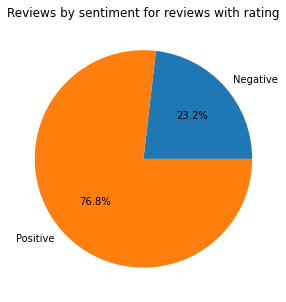

In [82]:
#Plot sentiment of text only for records with rating
labels, frequencies = np.unique(data_full.dropna(subset = ['review_rating']).review_sentiment.values, return_counts = True)
plt.figure(figsize = (5,5))
labels = 'Negative','Positive'
plt.pie(frequencies,labels =labels, autopct = '%1.1f%%')
plt.title('Reviews by sentiment for reviews with rating')
plt.savefig('reviews_sentiment_calculated_from_review_rating.png', transparent=True)
plt.show()

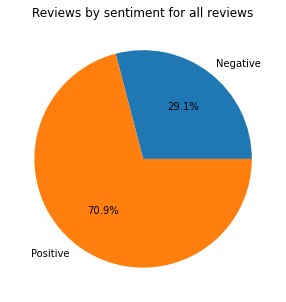

In [83]:
#Plot sentiment of text for records with rating and recods with prediction
labels, frequencies = np.unique(data_full.review_sentiment_actual_predicted.values, return_counts = True)
plt.figure(figsize = (5,5))
labels = 'Negative','Positive'
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title('Reviews by sentiment for all reviews')
plt.savefig('reviews_sentiment_calculated_from_review_rating_prediction.png', transparent=True)
plt.show()

*From the plots above we can see that the model predicts bigger fraction of negative sentiment reviews among records without filled rating in comparison to reviews with rating.
If we compare data with only filled rating and all data (with predicted sentiment), we can see that fraction of positive sentiment reviews drops by 5.9% (from 76.8% to 70.9%).*